# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

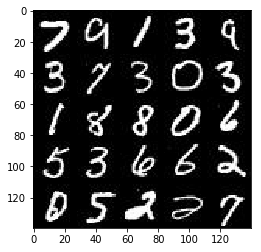

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

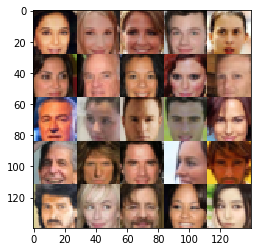

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # input : 28 * 28 * n
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                 padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 14 * 14 * 64
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                 padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 7 * 7 * 128
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2,
                                 kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                 padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        # 4 * 4 * 256
        
        flat = tf.reshape(conv2, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7 * 7 * 512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14 * 14 * 256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28 * 28 * 128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28 * 28 * 64

        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='same')
        out = tf.tanh(logits)
    
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(images=input_real)
    d_model_fake, d_logits_fake= discriminator(images=g_model, reuse=True)
    
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    out_channel_dim = data_shape[3]
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0  # Why we are doing this ?
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 1.7534... Generator Loss: 0.4199
Epoch 1/2... Batch 20... Discriminator Loss: 1.4382... Generator Loss: 0.5795
Epoch 1/2... Batch 30... Discriminator Loss: 1.2707... Generator Loss: 0.7767
Epoch 1/2... Batch 40... Discriminator Loss: 1.0458... Generator Loss: 0.9418
Epoch 1/2... Batch 50... Discriminator Loss: 0.7781... Generator Loss: 1.3226
Epoch 1/2... Batch 60... Discriminator Loss: 0.8086... Generator Loss: 1.2235
Epoch 1/2... Batch 70... Discriminator Loss: 0.7571... Generator Loss: 1.4270
Epoch 1/2... Batch 80... Discriminator Loss: 0.8940... Generator Loss: 1.1478
Epoch 1/2... Batch 90... Discriminator Loss: 0.9001... Generator Loss: 1.1047
Epoch 1/2... Batch 100... Discriminator Loss: 0.5886... Generator Loss: 1.8169


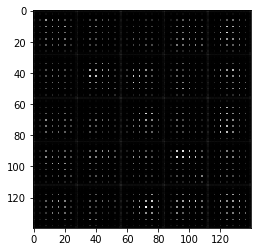

Epoch 1/2... Batch 110... Discriminator Loss: 0.4494... Generator Loss: 2.4980
Epoch 1/2... Batch 120... Discriminator Loss: 0.8368... Generator Loss: 1.1985
Epoch 1/2... Batch 130... Discriminator Loss: 1.3697... Generator Loss: 1.0418
Epoch 1/2... Batch 140... Discriminator Loss: 1.4365... Generator Loss: 0.7526
Epoch 1/2... Batch 150... Discriminator Loss: 1.3496... Generator Loss: 0.8200
Epoch 1/2... Batch 160... Discriminator Loss: 1.3470... Generator Loss: 0.7839
Epoch 1/2... Batch 170... Discriminator Loss: 1.3551... Generator Loss: 0.7572
Epoch 1/2... Batch 180... Discriminator Loss: 1.2816... Generator Loss: 0.8564
Epoch 1/2... Batch 190... Discriminator Loss: 1.3539... Generator Loss: 0.7695
Epoch 1/2... Batch 200... Discriminator Loss: 1.4053... Generator Loss: 0.7176


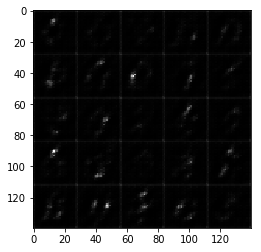

Epoch 1/2... Batch 210... Discriminator Loss: 1.3307... Generator Loss: 0.7672
Epoch 1/2... Batch 220... Discriminator Loss: 1.3445... Generator Loss: 0.7854
Epoch 1/2... Batch 230... Discriminator Loss: 1.3909... Generator Loss: 0.7184
Epoch 1/2... Batch 240... Discriminator Loss: 1.3964... Generator Loss: 0.7575
Epoch 1/2... Batch 250... Discriminator Loss: 1.3737... Generator Loss: 0.7562
Epoch 1/2... Batch 260... Discriminator Loss: 1.3658... Generator Loss: 0.7512
Epoch 1/2... Batch 270... Discriminator Loss: 1.3933... Generator Loss: 0.7347
Epoch 1/2... Batch 280... Discriminator Loss: 1.3910... Generator Loss: 0.7266
Epoch 1/2... Batch 290... Discriminator Loss: 1.3834... Generator Loss: 0.7563
Epoch 1/2... Batch 300... Discriminator Loss: 1.3501... Generator Loss: 0.7449


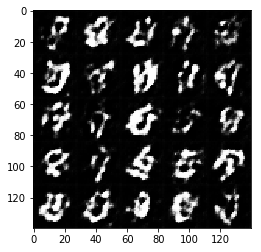

Epoch 1/2... Batch 310... Discriminator Loss: 1.3377... Generator Loss: 0.8040
Epoch 1/2... Batch 320... Discriminator Loss: 1.3196... Generator Loss: 0.8100
Epoch 1/2... Batch 330... Discriminator Loss: 1.3560... Generator Loss: 0.7586
Epoch 1/2... Batch 340... Discriminator Loss: 1.3344... Generator Loss: 0.7921
Epoch 1/2... Batch 350... Discriminator Loss: 1.3612... Generator Loss: 0.7624
Epoch 1/2... Batch 360... Discriminator Loss: 1.3417... Generator Loss: 0.7667
Epoch 1/2... Batch 370... Discriminator Loss: 1.3176... Generator Loss: 0.7835
Epoch 1/2... Batch 380... Discriminator Loss: 1.2969... Generator Loss: 0.8095
Epoch 1/2... Batch 390... Discriminator Loss: 1.3598... Generator Loss: 0.7772
Epoch 1/2... Batch 400... Discriminator Loss: 1.3489... Generator Loss: 0.7782


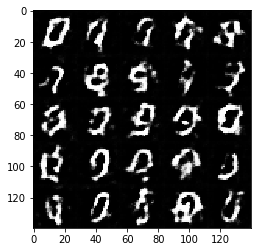

Epoch 1/2... Batch 410... Discriminator Loss: 1.3517... Generator Loss: 0.7762
Epoch 1/2... Batch 420... Discriminator Loss: 1.3103... Generator Loss: 0.8077
Epoch 1/2... Batch 430... Discriminator Loss: 1.3599... Generator Loss: 0.7490
Epoch 1/2... Batch 440... Discriminator Loss: 1.3281... Generator Loss: 0.7944
Epoch 1/2... Batch 450... Discriminator Loss: 1.3180... Generator Loss: 0.7790
Epoch 1/2... Batch 460... Discriminator Loss: 1.3919... Generator Loss: 0.7687
Epoch 1/2... Batch 470... Discriminator Loss: 1.2894... Generator Loss: 0.8092
Epoch 1/2... Batch 480... Discriminator Loss: 1.3348... Generator Loss: 0.7790
Epoch 1/2... Batch 490... Discriminator Loss: 1.2647... Generator Loss: 0.8337
Epoch 1/2... Batch 500... Discriminator Loss: 1.3309... Generator Loss: 0.7599


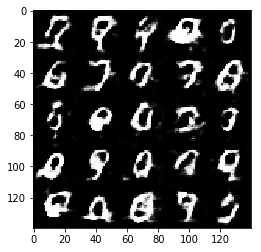

Epoch 1/2... Batch 510... Discriminator Loss: 1.3014... Generator Loss: 0.7955
Epoch 1/2... Batch 520... Discriminator Loss: 1.3050... Generator Loss: 0.8307
Epoch 1/2... Batch 530... Discriminator Loss: 1.3114... Generator Loss: 0.7950
Epoch 1/2... Batch 540... Discriminator Loss: 1.2989... Generator Loss: 0.8119
Epoch 1/2... Batch 550... Discriminator Loss: 1.2852... Generator Loss: 0.8173
Epoch 1/2... Batch 560... Discriminator Loss: 1.2905... Generator Loss: 0.8119
Epoch 1/2... Batch 570... Discriminator Loss: 1.3033... Generator Loss: 0.7944
Epoch 1/2... Batch 580... Discriminator Loss: 1.2965... Generator Loss: 0.8352
Epoch 1/2... Batch 590... Discriminator Loss: 1.2885... Generator Loss: 0.8107
Epoch 1/2... Batch 600... Discriminator Loss: 1.2869... Generator Loss: 0.8103


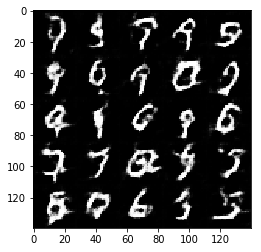

Epoch 1/2... Batch 610... Discriminator Loss: 1.2879... Generator Loss: 0.8324
Epoch 1/2... Batch 620... Discriminator Loss: 1.3132... Generator Loss: 0.8362
Epoch 1/2... Batch 630... Discriminator Loss: 1.3110... Generator Loss: 0.8190
Epoch 1/2... Batch 640... Discriminator Loss: 1.3246... Generator Loss: 0.8204
Epoch 1/2... Batch 650... Discriminator Loss: 1.3185... Generator Loss: 0.7867
Epoch 1/2... Batch 660... Discriminator Loss: 1.3713... Generator Loss: 0.7947
Epoch 1/2... Batch 670... Discriminator Loss: 1.3176... Generator Loss: 0.8523
Epoch 1/2... Batch 680... Discriminator Loss: 1.3055... Generator Loss: 0.8222
Epoch 1/2... Batch 690... Discriminator Loss: 1.3119... Generator Loss: 0.8352
Epoch 1/2... Batch 700... Discriminator Loss: 1.3032... Generator Loss: 0.8142


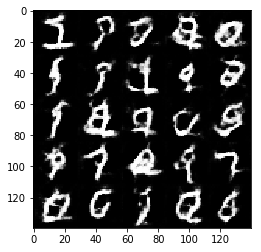

Epoch 1/2... Batch 710... Discriminator Loss: 1.3488... Generator Loss: 0.7866
Epoch 1/2... Batch 720... Discriminator Loss: 1.3252... Generator Loss: 0.8011
Epoch 1/2... Batch 730... Discriminator Loss: 1.3058... Generator Loss: 0.8114
Epoch 1/2... Batch 740... Discriminator Loss: 1.3361... Generator Loss: 0.7920
Epoch 1/2... Batch 750... Discriminator Loss: 1.3364... Generator Loss: 0.8258
Epoch 1/2... Batch 760... Discriminator Loss: 1.3000... Generator Loss: 0.8503
Epoch 1/2... Batch 770... Discriminator Loss: 1.3543... Generator Loss: 0.7943
Epoch 1/2... Batch 780... Discriminator Loss: 1.3817... Generator Loss: 0.7581
Epoch 1/2... Batch 790... Discriminator Loss: 1.3301... Generator Loss: 0.8429
Epoch 1/2... Batch 800... Discriminator Loss: 1.3448... Generator Loss: 0.7875


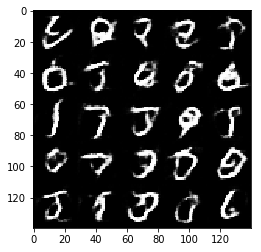

Epoch 1/2... Batch 810... Discriminator Loss: 1.3499... Generator Loss: 0.7690
Epoch 1/2... Batch 820... Discriminator Loss: 1.3581... Generator Loss: 0.7513
Epoch 1/2... Batch 830... Discriminator Loss: 1.3289... Generator Loss: 0.8113
Epoch 1/2... Batch 840... Discriminator Loss: 1.3461... Generator Loss: 0.7541
Epoch 1/2... Batch 850... Discriminator Loss: 1.3333... Generator Loss: 0.7960
Epoch 1/2... Batch 860... Discriminator Loss: 1.3478... Generator Loss: 0.8130
Epoch 1/2... Batch 870... Discriminator Loss: 1.3744... Generator Loss: 0.7945
Epoch 1/2... Batch 880... Discriminator Loss: 1.3482... Generator Loss: 0.8149
Epoch 1/2... Batch 890... Discriminator Loss: 1.3518... Generator Loss: 0.8071
Epoch 1/2... Batch 900... Discriminator Loss: 1.3513... Generator Loss: 0.8137


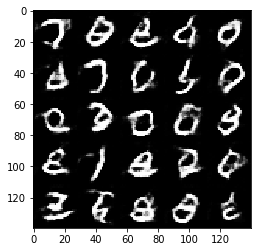

Epoch 1/2... Batch 910... Discriminator Loss: 1.3740... Generator Loss: 0.7624
Epoch 1/2... Batch 920... Discriminator Loss: 1.3268... Generator Loss: 0.7553
Epoch 1/2... Batch 930... Discriminator Loss: 1.3504... Generator Loss: 0.7782
Epoch 2/2... Batch 940... Discriminator Loss: 1.3536... Generator Loss: 0.7483
Epoch 2/2... Batch 950... Discriminator Loss: 1.3399... Generator Loss: 0.7984
Epoch 2/2... Batch 960... Discriminator Loss: 1.3452... Generator Loss: 0.8123
Epoch 2/2... Batch 970... Discriminator Loss: 1.3113... Generator Loss: 0.8058
Epoch 2/2... Batch 980... Discriminator Loss: 1.3567... Generator Loss: 0.8022
Epoch 2/2... Batch 990... Discriminator Loss: 1.3556... Generator Loss: 0.8432
Epoch 2/2... Batch 1000... Discriminator Loss: 1.3740... Generator Loss: 0.7827


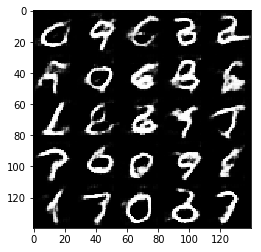

Epoch 2/2... Batch 1010... Discriminator Loss: 1.3180... Generator Loss: 0.8138
Epoch 2/2... Batch 1020... Discriminator Loss: 1.3312... Generator Loss: 0.8113
Epoch 2/2... Batch 1030... Discriminator Loss: 1.3617... Generator Loss: 0.7679
Epoch 2/2... Batch 1040... Discriminator Loss: 1.3837... Generator Loss: 0.7852
Epoch 2/2... Batch 1050... Discriminator Loss: 1.3598... Generator Loss: 0.8176
Epoch 2/2... Batch 1060... Discriminator Loss: 1.3308... Generator Loss: 0.8057
Epoch 2/2... Batch 1070... Discriminator Loss: 1.3691... Generator Loss: 0.7256
Epoch 2/2... Batch 1080... Discriminator Loss: 1.3419... Generator Loss: 0.8127
Epoch 2/2... Batch 1090... Discriminator Loss: 1.3263... Generator Loss: 0.8481
Epoch 2/2... Batch 1100... Discriminator Loss: 1.3736... Generator Loss: 0.7724


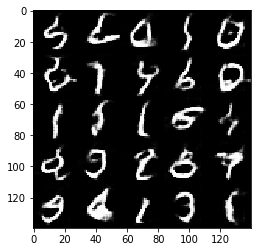

Epoch 2/2... Batch 1110... Discriminator Loss: 1.3409... Generator Loss: 0.8219
Epoch 2/2... Batch 1120... Discriminator Loss: 1.3101... Generator Loss: 0.8416
Epoch 2/2... Batch 1130... Discriminator Loss: 1.3341... Generator Loss: 0.7717
Epoch 2/2... Batch 1140... Discriminator Loss: 1.3389... Generator Loss: 0.7829
Epoch 2/2... Batch 1150... Discriminator Loss: 1.3450... Generator Loss: 0.8081
Epoch 2/2... Batch 1160... Discriminator Loss: 1.2920... Generator Loss: 0.8368
Epoch 2/2... Batch 1170... Discriminator Loss: 1.3293... Generator Loss: 0.7751
Epoch 2/2... Batch 1180... Discriminator Loss: 1.3185... Generator Loss: 0.7819
Epoch 2/2... Batch 1190... Discriminator Loss: 1.3704... Generator Loss: 0.7370
Epoch 2/2... Batch 1200... Discriminator Loss: 1.3272... Generator Loss: 0.8315


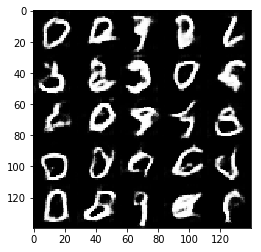

Epoch 2/2... Batch 1210... Discriminator Loss: 1.3568... Generator Loss: 0.7712
Epoch 2/2... Batch 1220... Discriminator Loss: 1.3217... Generator Loss: 0.7968
Epoch 2/2... Batch 1230... Discriminator Loss: 1.3635... Generator Loss: 0.7945
Epoch 2/2... Batch 1240... Discriminator Loss: 1.3195... Generator Loss: 0.8148
Epoch 2/2... Batch 1250... Discriminator Loss: 1.3402... Generator Loss: 0.7503
Epoch 2/2... Batch 1260... Discriminator Loss: 1.3022... Generator Loss: 0.8656
Epoch 2/2... Batch 1270... Discriminator Loss: 1.3219... Generator Loss: 0.7796
Epoch 2/2... Batch 1280... Discriminator Loss: 1.2955... Generator Loss: 0.8331
Epoch 2/2... Batch 1290... Discriminator Loss: 1.3721... Generator Loss: 0.7973
Epoch 2/2... Batch 1300... Discriminator Loss: 1.3677... Generator Loss: 0.7921


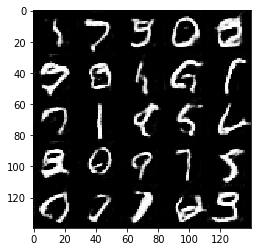

Epoch 2/2... Batch 1310... Discriminator Loss: 1.3269... Generator Loss: 0.8487
Epoch 2/2... Batch 1320... Discriminator Loss: 1.3534... Generator Loss: 0.8068
Epoch 2/2... Batch 1330... Discriminator Loss: 1.3457... Generator Loss: 0.7930
Epoch 2/2... Batch 1340... Discriminator Loss: 1.3478... Generator Loss: 0.8176
Epoch 2/2... Batch 1350... Discriminator Loss: 1.3285... Generator Loss: 0.7995
Epoch 2/2... Batch 1360... Discriminator Loss: 1.3305... Generator Loss: 0.8145
Epoch 2/2... Batch 1370... Discriminator Loss: 1.3406... Generator Loss: 0.7836
Epoch 2/2... Batch 1380... Discriminator Loss: 1.4032... Generator Loss: 0.7179
Epoch 2/2... Batch 1390... Discriminator Loss: 1.3217... Generator Loss: 0.8191
Epoch 2/2... Batch 1400... Discriminator Loss: 1.2893... Generator Loss: 0.8544


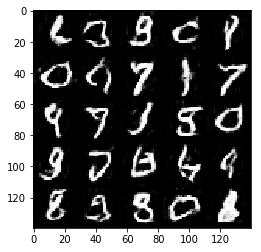

Epoch 2/2... Batch 1410... Discriminator Loss: 1.3295... Generator Loss: 0.8086
Epoch 2/2... Batch 1420... Discriminator Loss: 1.3044... Generator Loss: 0.8495
Epoch 2/2... Batch 1430... Discriminator Loss: 1.3383... Generator Loss: 0.7971
Epoch 2/2... Batch 1440... Discriminator Loss: 1.3747... Generator Loss: 0.7688
Epoch 2/2... Batch 1450... Discriminator Loss: 1.3600... Generator Loss: 0.8096
Epoch 2/2... Batch 1460... Discriminator Loss: 1.3353... Generator Loss: 0.8020
Epoch 2/2... Batch 1470... Discriminator Loss: 1.3427... Generator Loss: 0.7929
Epoch 2/2... Batch 1480... Discriminator Loss: 1.3661... Generator Loss: 0.7780
Epoch 2/2... Batch 1490... Discriminator Loss: 1.3070... Generator Loss: 0.8353
Epoch 2/2... Batch 1500... Discriminator Loss: 1.3217... Generator Loss: 0.8358


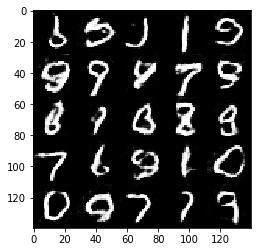

Epoch 2/2... Batch 1510... Discriminator Loss: 1.3368... Generator Loss: 0.7482
Epoch 2/2... Batch 1520... Discriminator Loss: 1.3729... Generator Loss: 0.7887
Epoch 2/2... Batch 1530... Discriminator Loss: 1.3253... Generator Loss: 0.8396
Epoch 2/2... Batch 1540... Discriminator Loss: 1.3600... Generator Loss: 0.8245
Epoch 2/2... Batch 1550... Discriminator Loss: 1.3219... Generator Loss: 0.7899
Epoch 2/2... Batch 1560... Discriminator Loss: 1.3047... Generator Loss: 0.8064
Epoch 2/2... Batch 1570... Discriminator Loss: 1.3594... Generator Loss: 0.7899
Epoch 2/2... Batch 1580... Discriminator Loss: 1.3578... Generator Loss: 0.8078
Epoch 2/2... Batch 1590... Discriminator Loss: 1.3489... Generator Loss: 0.7706
Epoch 2/2... Batch 1600... Discriminator Loss: 1.3346... Generator Loss: 0.8075


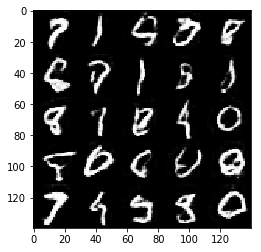

Epoch 2/2... Batch 1610... Discriminator Loss: 1.3143... Generator Loss: 0.7887
Epoch 2/2... Batch 1620... Discriminator Loss: 1.3833... Generator Loss: 0.7530
Epoch 2/2... Batch 1630... Discriminator Loss: 1.3316... Generator Loss: 0.8229
Epoch 2/2... Batch 1640... Discriminator Loss: 1.3305... Generator Loss: 0.7927
Epoch 2/2... Batch 1650... Discriminator Loss: 1.3404... Generator Loss: 0.7665
Epoch 2/2... Batch 1660... Discriminator Loss: 1.3448... Generator Loss: 0.7668
Epoch 2/2... Batch 1670... Discriminator Loss: 1.3390... Generator Loss: 0.8317
Epoch 2/2... Batch 1680... Discriminator Loss: 1.3422... Generator Loss: 0.8048
Epoch 2/2... Batch 1690... Discriminator Loss: 1.3518... Generator Loss: 0.8154
Epoch 2/2... Batch 1700... Discriminator Loss: 1.3127... Generator Loss: 0.8120


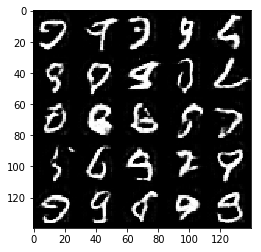

Epoch 2/2... Batch 1710... Discriminator Loss: 1.3598... Generator Loss: 0.8047
Epoch 2/2... Batch 1720... Discriminator Loss: 1.3529... Generator Loss: 0.8094
Epoch 2/2... Batch 1730... Discriminator Loss: 1.3383... Generator Loss: 0.8024
Epoch 2/2... Batch 1740... Discriminator Loss: 1.3417... Generator Loss: 0.8149
Epoch 2/2... Batch 1750... Discriminator Loss: 1.3253... Generator Loss: 0.8272
Epoch 2/2... Batch 1760... Discriminator Loss: 1.3536... Generator Loss: 0.7794
Epoch 2/2... Batch 1770... Discriminator Loss: 1.3726... Generator Loss: 0.7751
Epoch 2/2... Batch 1780... Discriminator Loss: 1.3342... Generator Loss: 0.7461
Epoch 2/2... Batch 1790... Discriminator Loss: 1.3761... Generator Loss: 0.8690
Epoch 2/2... Batch 1800... Discriminator Loss: 1.3475... Generator Loss: 0.8102


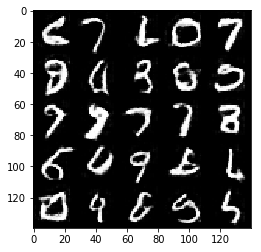

Epoch 2/2... Batch 1810... Discriminator Loss: 1.3742... Generator Loss: 0.7565
Epoch 2/2... Batch 1820... Discriminator Loss: 1.3368... Generator Loss: 0.8442
Epoch 2/2... Batch 1830... Discriminator Loss: 1.3308... Generator Loss: 0.8050
Epoch 2/2... Batch 1840... Discriminator Loss: 1.3891... Generator Loss: 0.7506
Epoch 2/2... Batch 1850... Discriminator Loss: 1.3515... Generator Loss: 0.7761
Epoch 2/2... Batch 1860... Discriminator Loss: 1.3525... Generator Loss: 0.8355
Epoch 2/2... Batch 1870... Discriminator Loss: 1.3848... Generator Loss: 0.7905


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Batch 10... Discriminator Loss: 2.7930... Generator Loss: 0.1492
Epoch 1/2... Batch 20... Discriminator Loss: 2.4701... Generator Loss: 0.2190
Epoch 1/2... Batch 30... Discriminator Loss: 2.0708... Generator Loss: 0.3364
Epoch 1/2... Batch 40... Discriminator Loss: 1.8386... Generator Loss: 0.4208
Epoch 1/2... Batch 50... Discriminator Loss: 1.6362... Generator Loss: 0.5079
Epoch 1/2... Batch 60... Discriminator Loss: 1.4724... Generator Loss: 0.5949
Epoch 1/2... Batch 70... Discriminator Loss: 1.4858... Generator Loss: 0.5782
Epoch 1/2... Batch 80... Discriminator Loss: 1.3616... Generator Loss: 0.6474
Epoch 1/2... Batch 90... Discriminator Loss: 1.3145... Generator Loss: 0.6886
Epoch 1/2... Batch 100... Discriminator Loss: 1.1704... Generator Loss: 0.7829


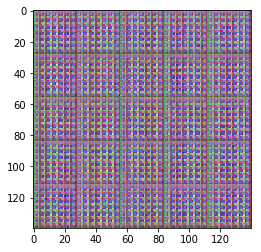

Epoch 1/2... Batch 110... Discriminator Loss: 1.2231... Generator Loss: 0.7265
Epoch 1/2... Batch 120... Discriminator Loss: 1.0608... Generator Loss: 0.8979
Epoch 1/2... Batch 130... Discriminator Loss: 0.9149... Generator Loss: 1.0997
Epoch 1/2... Batch 140... Discriminator Loss: 0.7806... Generator Loss: 1.3220
Epoch 1/2... Batch 150... Discriminator Loss: 0.7614... Generator Loss: 1.3022
Epoch 1/2... Batch 160... Discriminator Loss: 0.6955... Generator Loss: 1.5279
Epoch 1/2... Batch 170... Discriminator Loss: 0.7166... Generator Loss: 1.4164
Epoch 1/2... Batch 180... Discriminator Loss: 0.6176... Generator Loss: 1.7676
Epoch 1/2... Batch 190... Discriminator Loss: 0.5825... Generator Loss: 1.7906
Epoch 1/2... Batch 200... Discriminator Loss: 0.5961... Generator Loss: 1.7608


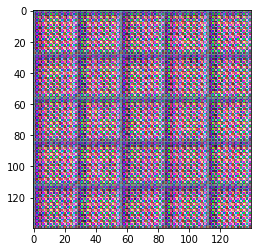

Epoch 1/2... Batch 210... Discriminator Loss: 0.5874... Generator Loss: 1.7912
Epoch 1/2... Batch 220... Discriminator Loss: 0.5780... Generator Loss: 1.8419
Epoch 1/2... Batch 230... Discriminator Loss: 0.5808... Generator Loss: 1.9056
Epoch 1/2... Batch 240... Discriminator Loss: 0.5530... Generator Loss: 1.9570
Epoch 1/2... Batch 250... Discriminator Loss: 0.6372... Generator Loss: 1.8047
Epoch 1/2... Batch 260... Discriminator Loss: 0.6612... Generator Loss: 1.6365
Epoch 1/2... Batch 270... Discriminator Loss: 0.8375... Generator Loss: 1.4096
Epoch 1/2... Batch 280... Discriminator Loss: 0.7708... Generator Loss: 1.6479
Epoch 1/2... Batch 290... Discriminator Loss: 0.8420... Generator Loss: 1.4563
Epoch 1/2... Batch 300... Discriminator Loss: 0.8287... Generator Loss: 1.2608


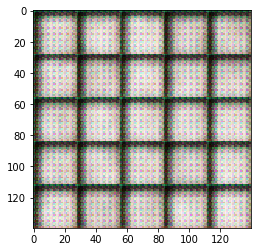

Epoch 1/2... Batch 310... Discriminator Loss: 0.7845... Generator Loss: 1.3752
Epoch 1/2... Batch 320... Discriminator Loss: 0.8540... Generator Loss: 1.1890
Epoch 1/2... Batch 330... Discriminator Loss: 0.7250... Generator Loss: 1.4421
Epoch 1/2... Batch 340... Discriminator Loss: 0.7506... Generator Loss: 1.5008
Epoch 1/2... Batch 350... Discriminator Loss: 0.9162... Generator Loss: 1.0752
Epoch 1/2... Batch 360... Discriminator Loss: 0.5890... Generator Loss: 2.0877
Epoch 1/2... Batch 370... Discriminator Loss: 0.5995... Generator Loss: 2.0780
Epoch 1/2... Batch 380... Discriminator Loss: 0.9477... Generator Loss: 1.0192
Epoch 1/2... Batch 390... Discriminator Loss: 0.8254... Generator Loss: 1.1409
Epoch 1/2... Batch 400... Discriminator Loss: 0.7115... Generator Loss: 1.6393


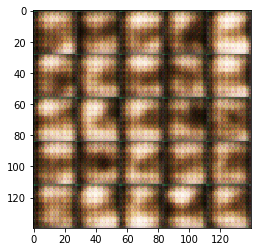

Epoch 1/2... Batch 410... Discriminator Loss: 0.7491... Generator Loss: 1.3275
Epoch 1/2... Batch 420... Discriminator Loss: 0.7138... Generator Loss: 1.4283
Epoch 1/2... Batch 430... Discriminator Loss: 0.6245... Generator Loss: 1.8859
Epoch 1/2... Batch 440... Discriminator Loss: 0.6570... Generator Loss: 1.6544
Epoch 1/2... Batch 450... Discriminator Loss: 0.6240... Generator Loss: 1.8827
Epoch 1/2... Batch 460... Discriminator Loss: 0.7629... Generator Loss: 1.3086
Epoch 1/2... Batch 470... Discriminator Loss: 0.8267... Generator Loss: 1.2409
Epoch 1/2... Batch 480... Discriminator Loss: 0.7127... Generator Loss: 1.4831
Epoch 1/2... Batch 490... Discriminator Loss: 0.7062... Generator Loss: 1.6274
Epoch 1/2... Batch 500... Discriminator Loss: 0.6942... Generator Loss: 1.5421


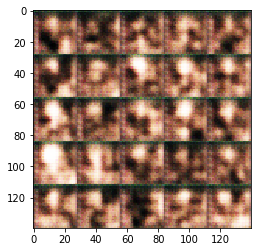

Epoch 1/2... Batch 510... Discriminator Loss: 0.5830... Generator Loss: 2.0701
Epoch 1/2... Batch 520... Discriminator Loss: 0.6264... Generator Loss: 1.6581
Epoch 1/2... Batch 530... Discriminator Loss: 0.5665... Generator Loss: 2.0258
Epoch 1/2... Batch 540... Discriminator Loss: 0.5537... Generator Loss: 2.2544
Epoch 1/2... Batch 550... Discriminator Loss: 0.6010... Generator Loss: 1.8148
Epoch 1/2... Batch 560... Discriminator Loss: 0.6293... Generator Loss: 1.7984
Epoch 1/2... Batch 570... Discriminator Loss: 0.5981... Generator Loss: 1.9285
Epoch 1/2... Batch 580... Discriminator Loss: 0.6043... Generator Loss: 1.8319
Epoch 1/2... Batch 590... Discriminator Loss: 0.6154... Generator Loss: 1.8521
Epoch 1/2... Batch 600... Discriminator Loss: 0.5392... Generator Loss: 2.3466


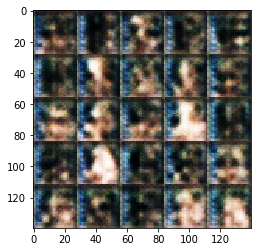

Epoch 1/2... Batch 610... Discriminator Loss: 0.5862... Generator Loss: 2.0419
Epoch 1/2... Batch 620... Discriminator Loss: 0.5739... Generator Loss: 2.3135
Epoch 1/2... Batch 630... Discriminator Loss: 0.7054... Generator Loss: 1.9199
Epoch 1/2... Batch 640... Discriminator Loss: 0.6275... Generator Loss: 1.7337
Epoch 1/2... Batch 650... Discriminator Loss: 0.7776... Generator Loss: 1.2337
Epoch 1/2... Batch 660... Discriminator Loss: 0.5387... Generator Loss: 2.2085
Epoch 1/2... Batch 670... Discriminator Loss: 0.8198... Generator Loss: 1.0579
Epoch 1/2... Batch 680... Discriminator Loss: 0.6737... Generator Loss: 1.7543
Epoch 1/2... Batch 690... Discriminator Loss: 0.6016... Generator Loss: 1.6948
Epoch 1/2... Batch 700... Discriminator Loss: 0.5557... Generator Loss: 2.3101


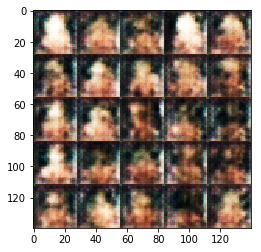

Epoch 1/2... Batch 710... Discriminator Loss: 0.6504... Generator Loss: 1.6200
Epoch 1/2... Batch 720... Discriminator Loss: 0.6462... Generator Loss: 1.8134
Epoch 1/2... Batch 730... Discriminator Loss: 0.6474... Generator Loss: 1.6901
Epoch 1/2... Batch 740... Discriminator Loss: 0.5269... Generator Loss: 2.7047
Epoch 1/2... Batch 750... Discriminator Loss: 0.5467... Generator Loss: 2.4342
Epoch 1/2... Batch 760... Discriminator Loss: 0.6543... Generator Loss: 1.8554
Epoch 1/2... Batch 770... Discriminator Loss: 0.6646... Generator Loss: 1.5528
Epoch 1/2... Batch 780... Discriminator Loss: 0.7063... Generator Loss: 1.4427
Epoch 1/2... Batch 790... Discriminator Loss: 0.7093... Generator Loss: 1.6197
Epoch 1/2... Batch 800... Discriminator Loss: 0.8171... Generator Loss: 1.7901


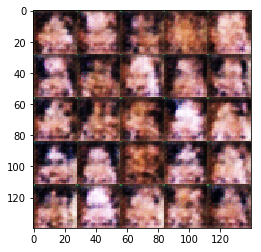

Epoch 1/2... Batch 810... Discriminator Loss: 0.6308... Generator Loss: 1.9681
Epoch 1/2... Batch 820... Discriminator Loss: 0.9754... Generator Loss: 1.7597
Epoch 1/2... Batch 830... Discriminator Loss: 0.8659... Generator Loss: 1.4290
Epoch 1/2... Batch 840... Discriminator Loss: 0.8017... Generator Loss: 1.4811
Epoch 1/2... Batch 850... Discriminator Loss: 0.8682... Generator Loss: 1.1290
Epoch 1/2... Batch 860... Discriminator Loss: 0.6399... Generator Loss: 1.8246
Epoch 1/2... Batch 870... Discriminator Loss: 0.7338... Generator Loss: 1.5028
Epoch 1/2... Batch 880... Discriminator Loss: 0.8129... Generator Loss: 1.2299
Epoch 1/2... Batch 890... Discriminator Loss: 0.5364... Generator Loss: 2.3902
Epoch 1/2... Batch 900... Discriminator Loss: 0.8642... Generator Loss: 1.4055


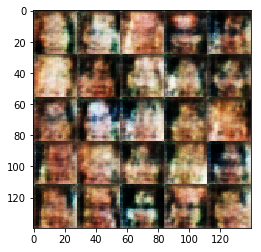

Epoch 1/2... Batch 910... Discriminator Loss: 0.7085... Generator Loss: 2.0599
Epoch 1/2... Batch 920... Discriminator Loss: 0.6604... Generator Loss: 1.6615
Epoch 1/2... Batch 930... Discriminator Loss: 0.5481... Generator Loss: 2.8472
Epoch 1/2... Batch 940... Discriminator Loss: 0.8186... Generator Loss: 1.2397
Epoch 1/2... Batch 950... Discriminator Loss: 1.0455... Generator Loss: 1.1393
Epoch 1/2... Batch 960... Discriminator Loss: 0.7530... Generator Loss: 1.9831
Epoch 1/2... Batch 970... Discriminator Loss: 0.7051... Generator Loss: 1.5653
Epoch 1/2... Batch 980... Discriminator Loss: 0.6553... Generator Loss: 1.7198
Epoch 1/2... Batch 990... Discriminator Loss: 0.9253... Generator Loss: 1.5123
Epoch 1/2... Batch 1000... Discriminator Loss: 0.6637... Generator Loss: 1.8174


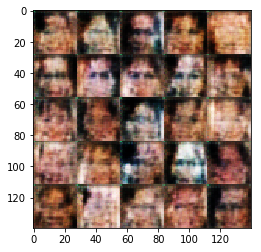

Epoch 1/2... Batch 1010... Discriminator Loss: 0.6523... Generator Loss: 2.3122
Epoch 1/2... Batch 1020... Discriminator Loss: 0.7600... Generator Loss: 1.3387
Epoch 1/2... Batch 1030... Discriminator Loss: 0.6186... Generator Loss: 2.1428
Epoch 1/2... Batch 1040... Discriminator Loss: 0.9651... Generator Loss: 1.0835
Epoch 1/2... Batch 1050... Discriminator Loss: 0.6865... Generator Loss: 2.0322
Epoch 1/2... Batch 1060... Discriminator Loss: 0.7330... Generator Loss: 1.7998
Epoch 1/2... Batch 1070... Discriminator Loss: 0.8298... Generator Loss: 1.2695
Epoch 1/2... Batch 1080... Discriminator Loss: 0.7827... Generator Loss: 1.4105
Epoch 1/2... Batch 1090... Discriminator Loss: 0.8436... Generator Loss: 1.2606
Epoch 1/2... Batch 1100... Discriminator Loss: 0.9526... Generator Loss: 1.0888


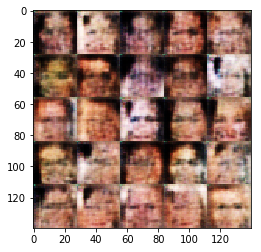

Epoch 1/2... Batch 1110... Discriminator Loss: 0.8017... Generator Loss: 1.7440
Epoch 1/2... Batch 1120... Discriminator Loss: 0.8640... Generator Loss: 1.1712
Epoch 1/2... Batch 1130... Discriminator Loss: 0.8169... Generator Loss: 1.3707
Epoch 1/2... Batch 1140... Discriminator Loss: 0.9186... Generator Loss: 1.2214
Epoch 1/2... Batch 1150... Discriminator Loss: 0.8097... Generator Loss: 1.3837
Epoch 1/2... Batch 1160... Discriminator Loss: 0.8116... Generator Loss: 1.5892
Epoch 1/2... Batch 1170... Discriminator Loss: 0.9780... Generator Loss: 1.1975
Epoch 1/2... Batch 1180... Discriminator Loss: 1.1130... Generator Loss: 1.0472
Epoch 1/2... Batch 1190... Discriminator Loss: 0.9094... Generator Loss: 1.4188
Epoch 1/2... Batch 1200... Discriminator Loss: 0.5117... Generator Loss: 3.3183


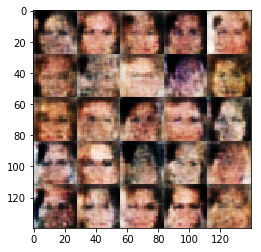

Epoch 1/2... Batch 1210... Discriminator Loss: 0.9008... Generator Loss: 1.0478
Epoch 1/2... Batch 1220... Discriminator Loss: 0.9872... Generator Loss: 1.1337
Epoch 1/2... Batch 1230... Discriminator Loss: 0.8969... Generator Loss: 1.2999
Epoch 1/2... Batch 1240... Discriminator Loss: 0.8953... Generator Loss: 1.4274
Epoch 1/2... Batch 1250... Discriminator Loss: 0.9391... Generator Loss: 1.2946
Epoch 1/2... Batch 1260... Discriminator Loss: 0.7036... Generator Loss: 1.8779
Epoch 1/2... Batch 1270... Discriminator Loss: 1.0380... Generator Loss: 1.0670
Epoch 1/2... Batch 1280... Discriminator Loss: 0.9453... Generator Loss: 1.3817
Epoch 1/2... Batch 1290... Discriminator Loss: 1.0392... Generator Loss: 0.9984
Epoch 1/2... Batch 1300... Discriminator Loss: 0.9922... Generator Loss: 1.1885


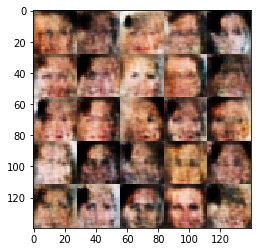

Epoch 1/2... Batch 1310... Discriminator Loss: 1.0657... Generator Loss: 1.0763
Epoch 1/2... Batch 1320... Discriminator Loss: 0.8244... Generator Loss: 1.4763
Epoch 1/2... Batch 1330... Discriminator Loss: 0.7171... Generator Loss: 1.7364
Epoch 1/2... Batch 1340... Discriminator Loss: 0.9151... Generator Loss: 1.2011
Epoch 1/2... Batch 1350... Discriminator Loss: 0.9827... Generator Loss: 1.2545
Epoch 1/2... Batch 1360... Discriminator Loss: 1.1170... Generator Loss: 0.9799
Epoch 1/2... Batch 1370... Discriminator Loss: 0.8370... Generator Loss: 1.4359
Epoch 1/2... Batch 1380... Discriminator Loss: 0.7819... Generator Loss: 1.5466
Epoch 1/2... Batch 1390... Discriminator Loss: 0.6331... Generator Loss: 2.2980
Epoch 1/2... Batch 1400... Discriminator Loss: 0.7963... Generator Loss: 1.5674


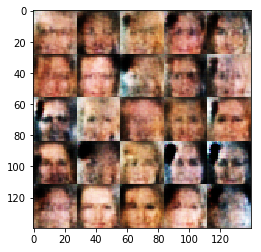

Epoch 1/2... Batch 1410... Discriminator Loss: 1.1173... Generator Loss: 0.9870
Epoch 1/2... Batch 1420... Discriminator Loss: 0.7963... Generator Loss: 1.4921
Epoch 1/2... Batch 1430... Discriminator Loss: 0.7520... Generator Loss: 1.6161
Epoch 1/2... Batch 1440... Discriminator Loss: 0.9015... Generator Loss: 1.3425
Epoch 1/2... Batch 1450... Discriminator Loss: 0.7001... Generator Loss: 1.9961
Epoch 1/2... Batch 1460... Discriminator Loss: 0.6164... Generator Loss: 2.4973
Epoch 1/2... Batch 1470... Discriminator Loss: 0.7991... Generator Loss: 1.4274
Epoch 1/2... Batch 1480... Discriminator Loss: 0.7264... Generator Loss: 1.8929
Epoch 1/2... Batch 1490... Discriminator Loss: 1.1001... Generator Loss: 1.0368
Epoch 1/2... Batch 1500... Discriminator Loss: 0.8151... Generator Loss: 1.3721


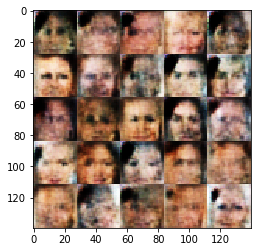

Epoch 1/2... Batch 1510... Discriminator Loss: 0.4376... Generator Loss: 4.8164
Epoch 1/2... Batch 1520... Discriminator Loss: 1.1325... Generator Loss: 1.0357
Epoch 1/2... Batch 1530... Discriminator Loss: 0.9750... Generator Loss: 1.2045
Epoch 1/2... Batch 1540... Discriminator Loss: 0.7809... Generator Loss: 1.5354
Epoch 1/2... Batch 1550... Discriminator Loss: 0.8926... Generator Loss: 1.3093
Epoch 1/2... Batch 1560... Discriminator Loss: 0.9665... Generator Loss: 1.2191
Epoch 1/2... Batch 1570... Discriminator Loss: 1.0648... Generator Loss: 1.0467
Epoch 1/2... Batch 1580... Discriminator Loss: 1.0372... Generator Loss: 1.1533
Epoch 1/2... Batch 1590... Discriminator Loss: 0.9498... Generator Loss: 1.2702
Epoch 1/2... Batch 1600... Discriminator Loss: 0.9091... Generator Loss: 1.2117


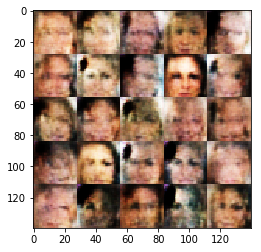

Epoch 1/2... Batch 1610... Discriminator Loss: 0.9885... Generator Loss: 1.1474
Epoch 1/2... Batch 1620... Discriminator Loss: 0.9938... Generator Loss: 1.0598
Epoch 1/2... Batch 1630... Discriminator Loss: 0.9060... Generator Loss: 1.3002
Epoch 1/2... Batch 1640... Discriminator Loss: 1.0372... Generator Loss: 1.1209
Epoch 1/2... Batch 1650... Discriminator Loss: 0.7211... Generator Loss: 1.8516
Epoch 1/2... Batch 1660... Discriminator Loss: 1.0676... Generator Loss: 1.0503
Epoch 1/2... Batch 1670... Discriminator Loss: 1.0747... Generator Loss: 1.0074
Epoch 1/2... Batch 1680... Discriminator Loss: 1.0500... Generator Loss: 0.9981
Epoch 1/2... Batch 1690... Discriminator Loss: 0.8650... Generator Loss: 1.3534
Epoch 1/2... Batch 1700... Discriminator Loss: 0.9121... Generator Loss: 1.2176


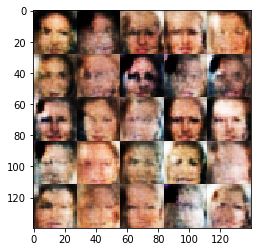

Epoch 1/2... Batch 1710... Discriminator Loss: 0.9641... Generator Loss: 1.2773
Epoch 1/2... Batch 1720... Discriminator Loss: 0.8973... Generator Loss: 1.2765
Epoch 1/2... Batch 1730... Discriminator Loss: 0.7301... Generator Loss: 1.8235
Epoch 1/2... Batch 1740... Discriminator Loss: 0.9940... Generator Loss: 1.0084
Epoch 1/2... Batch 1750... Discriminator Loss: 0.7632... Generator Loss: 1.8663
Epoch 1/2... Batch 1760... Discriminator Loss: 0.6718... Generator Loss: 2.0868
Epoch 1/2... Batch 1770... Discriminator Loss: 0.9638... Generator Loss: 1.1401
Epoch 1/2... Batch 1780... Discriminator Loss: 0.8811... Generator Loss: 1.3757
Epoch 1/2... Batch 1790... Discriminator Loss: 0.9089... Generator Loss: 1.3939
Epoch 1/2... Batch 1800... Discriminator Loss: 0.9160... Generator Loss: 1.2886


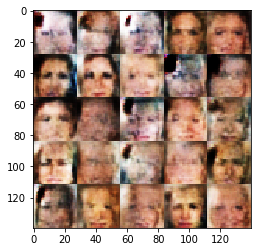

Epoch 1/2... Batch 1810... Discriminator Loss: 0.7769... Generator Loss: 1.9984
Epoch 1/2... Batch 1820... Discriminator Loss: 0.7922... Generator Loss: 1.8173
Epoch 1/2... Batch 1830... Discriminator Loss: 0.6402... Generator Loss: 2.2881
Epoch 1/2... Batch 1840... Discriminator Loss: 0.7564... Generator Loss: 2.3324
Epoch 1/2... Batch 1850... Discriminator Loss: 0.9873... Generator Loss: 1.3427
Epoch 1/2... Batch 1860... Discriminator Loss: 0.8261... Generator Loss: 1.4595
Epoch 1/2... Batch 1870... Discriminator Loss: 0.9724... Generator Loss: 1.2207
Epoch 1/2... Batch 1880... Discriminator Loss: 0.9329... Generator Loss: 1.2681
Epoch 1/2... Batch 1890... Discriminator Loss: 0.9278... Generator Loss: 1.2194
Epoch 1/2... Batch 1900... Discriminator Loss: 0.8958... Generator Loss: 1.4611


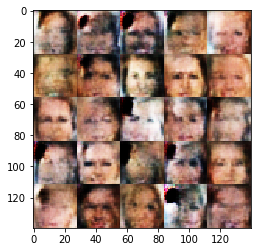

Epoch 1/2... Batch 1910... Discriminator Loss: 1.0095... Generator Loss: 1.1233
Epoch 1/2... Batch 1920... Discriminator Loss: 1.0097... Generator Loss: 1.1986
Epoch 1/2... Batch 1930... Discriminator Loss: 1.0473... Generator Loss: 1.0336
Epoch 1/2... Batch 1940... Discriminator Loss: 1.0438... Generator Loss: 1.1895
Epoch 1/2... Batch 1950... Discriminator Loss: 0.8213... Generator Loss: 1.7061
Epoch 1/2... Batch 1960... Discriminator Loss: 0.9148... Generator Loss: 1.3561
Epoch 1/2... Batch 1970... Discriminator Loss: 0.9665... Generator Loss: 0.9965
Epoch 1/2... Batch 1980... Discriminator Loss: 1.2655... Generator Loss: 1.1926
Epoch 1/2... Batch 1990... Discriminator Loss: 0.7879... Generator Loss: 1.7474
Epoch 1/2... Batch 2000... Discriminator Loss: 1.0067... Generator Loss: 1.0821


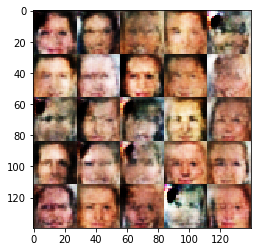

Epoch 1/2... Batch 2010... Discriminator Loss: 0.9631... Generator Loss: 1.2537
Epoch 1/2... Batch 2020... Discriminator Loss: 0.8961... Generator Loss: 1.4046
Epoch 1/2... Batch 2030... Discriminator Loss: 0.8710... Generator Loss: 1.4899
Epoch 1/2... Batch 2040... Discriminator Loss: 1.0365... Generator Loss: 1.2055
Epoch 1/2... Batch 2050... Discriminator Loss: 1.0283... Generator Loss: 1.0561
Epoch 1/2... Batch 2060... Discriminator Loss: 0.7960... Generator Loss: 1.8330
Epoch 1/2... Batch 2070... Discriminator Loss: 1.0325... Generator Loss: 1.1898
Epoch 1/2... Batch 2080... Discriminator Loss: 0.8976... Generator Loss: 1.2611
Epoch 1/2... Batch 2090... Discriminator Loss: 0.9225... Generator Loss: 1.3249
Epoch 1/2... Batch 2100... Discriminator Loss: 1.0550... Generator Loss: 1.0145


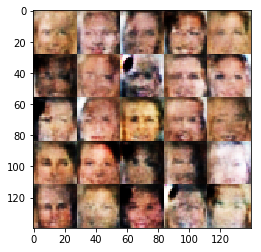

Epoch 1/2... Batch 2110... Discriminator Loss: 1.0154... Generator Loss: 1.1670
Epoch 1/2... Batch 2120... Discriminator Loss: 1.0121... Generator Loss: 1.1141
Epoch 1/2... Batch 2130... Discriminator Loss: 0.8722... Generator Loss: 1.3954
Epoch 1/2... Batch 2140... Discriminator Loss: 0.8686... Generator Loss: 1.4289
Epoch 1/2... Batch 2150... Discriminator Loss: 0.8419... Generator Loss: 1.3371
Epoch 1/2... Batch 2160... Discriminator Loss: 0.8854... Generator Loss: 1.6483
Epoch 1/2... Batch 2170... Discriminator Loss: 0.9135... Generator Loss: 1.4040
Epoch 1/2... Batch 2180... Discriminator Loss: 0.9141... Generator Loss: 1.2591
Epoch 1/2... Batch 2190... Discriminator Loss: 0.6734... Generator Loss: 2.2975
Epoch 1/2... Batch 2200... Discriminator Loss: 1.0209... Generator Loss: 1.0597


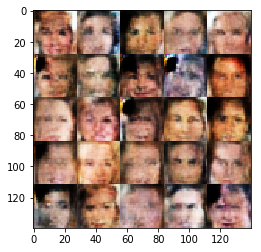

Epoch 1/2... Batch 2210... Discriminator Loss: 0.9605... Generator Loss: 1.2779
Epoch 1/2... Batch 2220... Discriminator Loss: 1.0017... Generator Loss: 1.2134
Epoch 1/2... Batch 2230... Discriminator Loss: 0.8028... Generator Loss: 1.4820
Epoch 1/2... Batch 2240... Discriminator Loss: 0.9255... Generator Loss: 1.3245
Epoch 1/2... Batch 2250... Discriminator Loss: 0.7692... Generator Loss: 1.9794
Epoch 1/2... Batch 2260... Discriminator Loss: 0.9521... Generator Loss: 1.4214
Epoch 1/2... Batch 2270... Discriminator Loss: 1.0436... Generator Loss: 1.1887
Epoch 1/2... Batch 2280... Discriminator Loss: 0.8573... Generator Loss: 1.4935
Epoch 1/2... Batch 2290... Discriminator Loss: 0.9334... Generator Loss: 1.5194
Epoch 1/2... Batch 2300... Discriminator Loss: 1.0016... Generator Loss: 1.0966


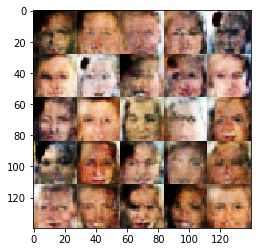

Epoch 1/2... Batch 2310... Discriminator Loss: 0.8113... Generator Loss: 1.6775
Epoch 1/2... Batch 2320... Discriminator Loss: 0.9580... Generator Loss: 1.3410
Epoch 1/2... Batch 2330... Discriminator Loss: 0.9807... Generator Loss: 1.1946
Epoch 1/2... Batch 2340... Discriminator Loss: 1.0004... Generator Loss: 1.1302
Epoch 1/2... Batch 2350... Discriminator Loss: 1.0073... Generator Loss: 1.1587
Epoch 1/2... Batch 2360... Discriminator Loss: 1.0454... Generator Loss: 0.9997
Epoch 1/2... Batch 2370... Discriminator Loss: 1.1639... Generator Loss: 0.8380
Epoch 1/2... Batch 2380... Discriminator Loss: 0.7914... Generator Loss: 1.9677
Epoch 1/2... Batch 2390... Discriminator Loss: 0.9683... Generator Loss: 1.0371
Epoch 1/2... Batch 2400... Discriminator Loss: 0.8533... Generator Loss: 1.5450


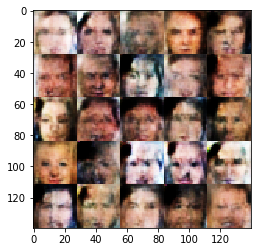

Epoch 1/2... Batch 2410... Discriminator Loss: 0.7296... Generator Loss: 1.8853
Epoch 1/2... Batch 2420... Discriminator Loss: 0.8934... Generator Loss: 1.4095
Epoch 1/2... Batch 2430... Discriminator Loss: 0.8471... Generator Loss: 1.7492
Epoch 1/2... Batch 2440... Discriminator Loss: 1.0054... Generator Loss: 1.1788
Epoch 1/2... Batch 2450... Discriminator Loss: 0.8807... Generator Loss: 1.6196
Epoch 1/2... Batch 2460... Discriminator Loss: 1.0878... Generator Loss: 1.1132
Epoch 1/2... Batch 2470... Discriminator Loss: 1.1651... Generator Loss: 1.1018
Epoch 1/2... Batch 2480... Discriminator Loss: 1.0241... Generator Loss: 1.1866
Epoch 1/2... Batch 2490... Discriminator Loss: 1.0922... Generator Loss: 0.9557
Epoch 1/2... Batch 2500... Discriminator Loss: 1.0521... Generator Loss: 0.9838


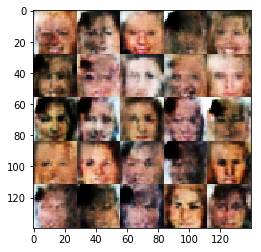

Epoch 1/2... Batch 2510... Discriminator Loss: 0.8917... Generator Loss: 1.3775
Epoch 1/2... Batch 2520... Discriminator Loss: 1.0899... Generator Loss: 1.1030
Epoch 1/2... Batch 2530... Discriminator Loss: 0.9042... Generator Loss: 1.3132
Epoch 1/2... Batch 2540... Discriminator Loss: 1.1153... Generator Loss: 0.9621
Epoch 1/2... Batch 2550... Discriminator Loss: 0.9757... Generator Loss: 1.3141
Epoch 1/2... Batch 2560... Discriminator Loss: 1.1738... Generator Loss: 1.0453
Epoch 1/2... Batch 2570... Discriminator Loss: 0.9147... Generator Loss: 1.4218
Epoch 1/2... Batch 2580... Discriminator Loss: 0.8321... Generator Loss: 1.5568
Epoch 1/2... Batch 2590... Discriminator Loss: 1.0405... Generator Loss: 1.0248
Epoch 1/2... Batch 2600... Discriminator Loss: 0.9879... Generator Loss: 1.2270


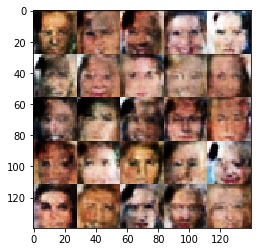

Epoch 1/2... Batch 2610... Discriminator Loss: 1.0814... Generator Loss: 1.0882
Epoch 1/2... Batch 2620... Discriminator Loss: 1.0919... Generator Loss: 1.2279
Epoch 1/2... Batch 2630... Discriminator Loss: 0.9565... Generator Loss: 1.1805
Epoch 1/2... Batch 2640... Discriminator Loss: 1.0198... Generator Loss: 1.1646
Epoch 1/2... Batch 2650... Discriminator Loss: 0.9367... Generator Loss: 1.3563
Epoch 1/2... Batch 2660... Discriminator Loss: 1.0212... Generator Loss: 1.1127
Epoch 1/2... Batch 2670... Discriminator Loss: 1.0524... Generator Loss: 1.2107
Epoch 1/2... Batch 2680... Discriminator Loss: 1.0180... Generator Loss: 0.9991
Epoch 1/2... Batch 2690... Discriminator Loss: 0.7736... Generator Loss: 1.9847
Epoch 1/2... Batch 2700... Discriminator Loss: 1.0678... Generator Loss: 1.2381


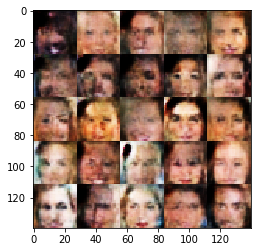

Epoch 1/2... Batch 2710... Discriminator Loss: 1.0104... Generator Loss: 1.0821
Epoch 1/2... Batch 2720... Discriminator Loss: 0.9567... Generator Loss: 1.2494
Epoch 1/2... Batch 2730... Discriminator Loss: 0.9760... Generator Loss: 1.2844
Epoch 1/2... Batch 2740... Discriminator Loss: 1.1672... Generator Loss: 0.9646
Epoch 1/2... Batch 2750... Discriminator Loss: 1.1271... Generator Loss: 0.9905
Epoch 1/2... Batch 2760... Discriminator Loss: 0.9572... Generator Loss: 1.1967
Epoch 1/2... Batch 2770... Discriminator Loss: 1.0663... Generator Loss: 1.1203
Epoch 1/2... Batch 2780... Discriminator Loss: 1.1560... Generator Loss: 0.9556
Epoch 1/2... Batch 2790... Discriminator Loss: 0.9006... Generator Loss: 1.3649
Epoch 1/2... Batch 2800... Discriminator Loss: 0.9985... Generator Loss: 1.2642


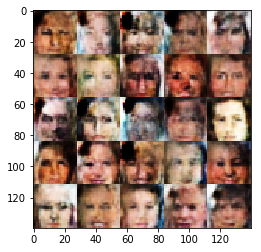

Epoch 1/2... Batch 2810... Discriminator Loss: 0.8800... Generator Loss: 1.6303
Epoch 1/2... Batch 2820... Discriminator Loss: 0.9773... Generator Loss: 1.2600
Epoch 1/2... Batch 2830... Discriminator Loss: 1.0398... Generator Loss: 1.0776
Epoch 1/2... Batch 2840... Discriminator Loss: 1.1582... Generator Loss: 0.9588
Epoch 1/2... Batch 2850... Discriminator Loss: 1.0136... Generator Loss: 1.1078
Epoch 1/2... Batch 2860... Discriminator Loss: 1.0778... Generator Loss: 1.0413
Epoch 1/2... Batch 2870... Discriminator Loss: 1.0731... Generator Loss: 1.0933
Epoch 1/2... Batch 2880... Discriminator Loss: 1.0532... Generator Loss: 1.0610
Epoch 1/2... Batch 2890... Discriminator Loss: 0.8730... Generator Loss: 1.3898
Epoch 1/2... Batch 2900... Discriminator Loss: 1.0968... Generator Loss: 0.9702


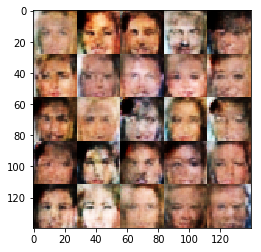

Epoch 1/2... Batch 2910... Discriminator Loss: 0.9254... Generator Loss: 1.4414
Epoch 1/2... Batch 2920... Discriminator Loss: 0.9233... Generator Loss: 1.2453
Epoch 1/2... Batch 2930... Discriminator Loss: 1.0394... Generator Loss: 1.0499
Epoch 1/2... Batch 2940... Discriminator Loss: 1.0825... Generator Loss: 0.9280
Epoch 1/2... Batch 2950... Discriminator Loss: 0.8744... Generator Loss: 1.8066
Epoch 1/2... Batch 2960... Discriminator Loss: 0.9718... Generator Loss: 1.1694
Epoch 1/2... Batch 2970... Discriminator Loss: 0.7998... Generator Loss: 1.3957
Epoch 1/2... Batch 2980... Discriminator Loss: 0.9701... Generator Loss: 1.2649
Epoch 1/2... Batch 2990... Discriminator Loss: 1.0159... Generator Loss: 1.1888
Epoch 1/2... Batch 3000... Discriminator Loss: 1.0720... Generator Loss: 1.6945


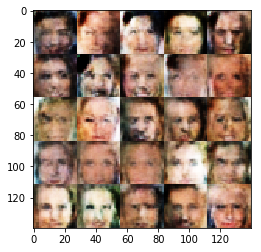

Epoch 1/2... Batch 3010... Discriminator Loss: 1.1159... Generator Loss: 1.0451
Epoch 1/2... Batch 3020... Discriminator Loss: 0.9746... Generator Loss: 1.5277
Epoch 1/2... Batch 3030... Discriminator Loss: 1.1459... Generator Loss: 0.9992
Epoch 1/2... Batch 3040... Discriminator Loss: 1.1329... Generator Loss: 1.0450
Epoch 1/2... Batch 3050... Discriminator Loss: 1.1734... Generator Loss: 1.1813
Epoch 1/2... Batch 3060... Discriminator Loss: 1.1716... Generator Loss: 0.9811
Epoch 1/2... Batch 3070... Discriminator Loss: 1.0848... Generator Loss: 1.0814
Epoch 1/2... Batch 3080... Discriminator Loss: 1.0710... Generator Loss: 1.1346
Epoch 1/2... Batch 3090... Discriminator Loss: 0.7312... Generator Loss: 1.8444
Epoch 1/2... Batch 3100... Discriminator Loss: 0.9316... Generator Loss: 1.2062


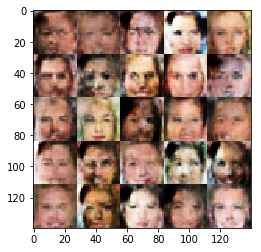

Epoch 1/2... Batch 3110... Discriminator Loss: 1.1316... Generator Loss: 1.1127
Epoch 1/2... Batch 3120... Discriminator Loss: 1.0800... Generator Loss: 1.0357
Epoch 1/2... Batch 3130... Discriminator Loss: 0.9760... Generator Loss: 1.2665
Epoch 1/2... Batch 3140... Discriminator Loss: 0.9821... Generator Loss: 1.3889
Epoch 1/2... Batch 3150... Discriminator Loss: 0.8782... Generator Loss: 1.3629
Epoch 1/2... Batch 3160... Discriminator Loss: 1.1423... Generator Loss: 0.9604
Epoch 2/2... Batch 3170... Discriminator Loss: 1.2067... Generator Loss: 0.9138
Epoch 2/2... Batch 3180... Discriminator Loss: 1.2105... Generator Loss: 1.0392
Epoch 2/2... Batch 3190... Discriminator Loss: 1.1294... Generator Loss: 0.9211
Epoch 2/2... Batch 3200... Discriminator Loss: 0.9760... Generator Loss: 1.2946


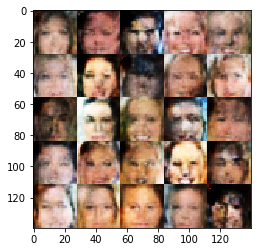

Epoch 2/2... Batch 3210... Discriminator Loss: 0.8388... Generator Loss: 1.8461
Epoch 2/2... Batch 3220... Discriminator Loss: 1.1351... Generator Loss: 0.9625
Epoch 2/2... Batch 3230... Discriminator Loss: 0.9253... Generator Loss: 1.3005
Epoch 2/2... Batch 3240... Discriminator Loss: 1.1774... Generator Loss: 1.0282
Epoch 2/2... Batch 3250... Discriminator Loss: 1.2100... Generator Loss: 0.7806
Epoch 2/2... Batch 3260... Discriminator Loss: 1.0396... Generator Loss: 1.2113
Epoch 2/2... Batch 3270... Discriminator Loss: 1.1226... Generator Loss: 1.1151
Epoch 2/2... Batch 3280... Discriminator Loss: 1.1077... Generator Loss: 1.1711
Epoch 2/2... Batch 3290... Discriminator Loss: 1.0947... Generator Loss: 1.0812
Epoch 2/2... Batch 3300... Discriminator Loss: 1.1336... Generator Loss: 0.9711


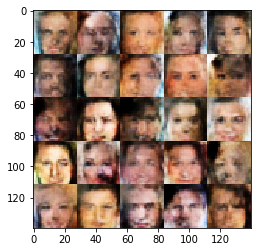

Epoch 2/2... Batch 3310... Discriminator Loss: 1.1234... Generator Loss: 1.1474
Epoch 2/2... Batch 3320... Discriminator Loss: 0.9837... Generator Loss: 1.4295
Epoch 2/2... Batch 3330... Discriminator Loss: 1.0535... Generator Loss: 1.1781
Epoch 2/2... Batch 3340... Discriminator Loss: 1.1522... Generator Loss: 1.1095
Epoch 2/2... Batch 3350... Discriminator Loss: 1.1452... Generator Loss: 1.0071
Epoch 2/2... Batch 3360... Discriminator Loss: 1.1009... Generator Loss: 1.1571
Epoch 2/2... Batch 3370... Discriminator Loss: 1.2196... Generator Loss: 0.9771
Epoch 2/2... Batch 3380... Discriminator Loss: 1.0824... Generator Loss: 1.2981
Epoch 2/2... Batch 3390... Discriminator Loss: 1.2235... Generator Loss: 0.8693
Epoch 2/2... Batch 3400... Discriminator Loss: 1.1155... Generator Loss: 1.0952


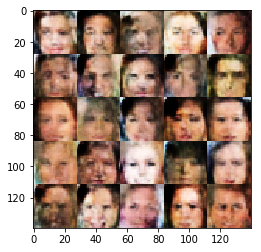

Epoch 2/2... Batch 3410... Discriminator Loss: 1.1086... Generator Loss: 0.9593
Epoch 2/2... Batch 3420... Discriminator Loss: 1.1459... Generator Loss: 0.9679
Epoch 2/2... Batch 3430... Discriminator Loss: 1.0952... Generator Loss: 1.3683
Epoch 2/2... Batch 3440... Discriminator Loss: 1.1246... Generator Loss: 1.1376
Epoch 2/2... Batch 3450... Discriminator Loss: 0.9447... Generator Loss: 1.5208
Epoch 2/2... Batch 3460... Discriminator Loss: 1.1413... Generator Loss: 0.9116
Epoch 2/2... Batch 3470... Discriminator Loss: 1.0767... Generator Loss: 1.0776
Epoch 2/2... Batch 3480... Discriminator Loss: 0.9573... Generator Loss: 1.5381
Epoch 2/2... Batch 3490... Discriminator Loss: 0.9311... Generator Loss: 1.5448
Epoch 2/2... Batch 3500... Discriminator Loss: 1.1390... Generator Loss: 1.0515


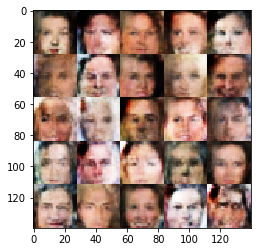

Epoch 2/2... Batch 3510... Discriminator Loss: 1.2053... Generator Loss: 0.8652
Epoch 2/2... Batch 3520... Discriminator Loss: 1.1135... Generator Loss: 0.9504
Epoch 2/2... Batch 3530... Discriminator Loss: 0.8553... Generator Loss: 1.8684
Epoch 2/2... Batch 3540... Discriminator Loss: 1.1571... Generator Loss: 1.0062
Epoch 2/2... Batch 3550... Discriminator Loss: 1.2148... Generator Loss: 0.9837
Epoch 2/2... Batch 3560... Discriminator Loss: 1.1827... Generator Loss: 0.8979
Epoch 2/2... Batch 3570... Discriminator Loss: 1.1522... Generator Loss: 0.9936
Epoch 2/2... Batch 3580... Discriminator Loss: 1.0375... Generator Loss: 1.1508
Epoch 2/2... Batch 3590... Discriminator Loss: 1.1174... Generator Loss: 1.0687
Epoch 2/2... Batch 3600... Discriminator Loss: 1.1194... Generator Loss: 1.0736


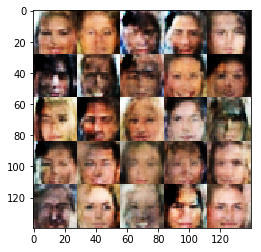

Epoch 2/2... Batch 3610... Discriminator Loss: 0.9198... Generator Loss: 1.7339
Epoch 2/2... Batch 3620... Discriminator Loss: 1.2037... Generator Loss: 0.8971
Epoch 2/2... Batch 3630... Discriminator Loss: 1.1134... Generator Loss: 0.9712
Epoch 2/2... Batch 3640... Discriminator Loss: 1.1846... Generator Loss: 1.0725
Epoch 2/2... Batch 3650... Discriminator Loss: 1.1134... Generator Loss: 0.9908
Epoch 2/2... Batch 3660... Discriminator Loss: 1.2298... Generator Loss: 0.8753
Epoch 2/2... Batch 3670... Discriminator Loss: 1.1691... Generator Loss: 1.0094
Epoch 2/2... Batch 3680... Discriminator Loss: 1.1253... Generator Loss: 1.2387
Epoch 2/2... Batch 3690... Discriminator Loss: 1.0779... Generator Loss: 1.2260
Epoch 2/2... Batch 3700... Discriminator Loss: 0.9439... Generator Loss: 1.8637


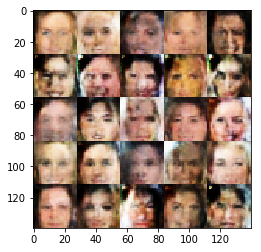

Epoch 2/2... Batch 3710... Discriminator Loss: 1.0534... Generator Loss: 1.1199
Epoch 2/2... Batch 3720... Discriminator Loss: 0.9938... Generator Loss: 1.4646
Epoch 2/2... Batch 3730... Discriminator Loss: 1.2321... Generator Loss: 1.0170
Epoch 2/2... Batch 3740... Discriminator Loss: 1.0987... Generator Loss: 1.3269
Epoch 2/2... Batch 3750... Discriminator Loss: 1.1529... Generator Loss: 0.8656
Epoch 2/2... Batch 3760... Discriminator Loss: 1.1360... Generator Loss: 1.1228
Epoch 2/2... Batch 3770... Discriminator Loss: 1.2204... Generator Loss: 0.9192
Epoch 2/2... Batch 3780... Discriminator Loss: 1.0150... Generator Loss: 1.2919
Epoch 2/2... Batch 3790... Discriminator Loss: 0.9300... Generator Loss: 1.7045
Epoch 2/2... Batch 3800... Discriminator Loss: 1.2384... Generator Loss: 1.0760


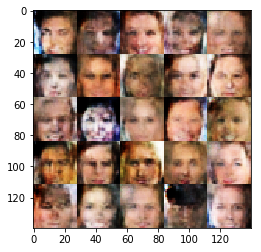

Epoch 2/2... Batch 3810... Discriminator Loss: 1.1471... Generator Loss: 0.9376
Epoch 2/2... Batch 3820... Discriminator Loss: 1.2468... Generator Loss: 0.9384
Epoch 2/2... Batch 3830... Discriminator Loss: 1.1515... Generator Loss: 1.0123
Epoch 2/2... Batch 3840... Discriminator Loss: 0.9628... Generator Loss: 1.5090
Epoch 2/2... Batch 3850... Discriminator Loss: 1.1863... Generator Loss: 0.9351
Epoch 2/2... Batch 3860... Discriminator Loss: 1.2032... Generator Loss: 0.9754
Epoch 2/2... Batch 3870... Discriminator Loss: 1.3648... Generator Loss: 0.9011
Epoch 2/2... Batch 3880... Discriminator Loss: 1.1180... Generator Loss: 0.9967
Epoch 2/2... Batch 3890... Discriminator Loss: 1.2466... Generator Loss: 0.8844
Epoch 2/2... Batch 3900... Discriminator Loss: 1.2183... Generator Loss: 1.0605


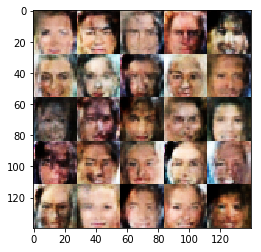

Epoch 2/2... Batch 3910... Discriminator Loss: 1.2311... Generator Loss: 0.8294
Epoch 2/2... Batch 3920... Discriminator Loss: 1.0276... Generator Loss: 1.6457
Epoch 2/2... Batch 3930... Discriminator Loss: 1.1116... Generator Loss: 1.0873
Epoch 2/2... Batch 3940... Discriminator Loss: 1.2472... Generator Loss: 0.8512
Epoch 2/2... Batch 3950... Discriminator Loss: 1.2304... Generator Loss: 1.1206
Epoch 2/2... Batch 3960... Discriminator Loss: 1.0637... Generator Loss: 1.2623
Epoch 2/2... Batch 3970... Discriminator Loss: 1.1549... Generator Loss: 0.9142
Epoch 2/2... Batch 3980... Discriminator Loss: 1.2059... Generator Loss: 0.8988
Epoch 2/2... Batch 3990... Discriminator Loss: 1.2320... Generator Loss: 1.0644
Epoch 2/2... Batch 4000... Discriminator Loss: 1.2424... Generator Loss: 0.8666


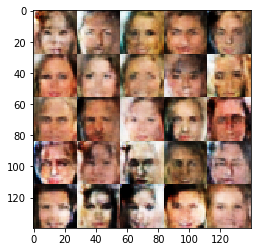

Epoch 2/2... Batch 4010... Discriminator Loss: 1.1216... Generator Loss: 1.0233
Epoch 2/2... Batch 4020... Discriminator Loss: 0.9239... Generator Loss: 1.8261
Epoch 2/2... Batch 4030... Discriminator Loss: 1.1400... Generator Loss: 0.9446
Epoch 2/2... Batch 4040... Discriminator Loss: 1.2525... Generator Loss: 0.9776
Epoch 2/2... Batch 4050... Discriminator Loss: 1.0968... Generator Loss: 1.2895
Epoch 2/2... Batch 4060... Discriminator Loss: 0.9935... Generator Loss: 1.0794
Epoch 2/2... Batch 4070... Discriminator Loss: 1.0419... Generator Loss: 1.1710
Epoch 2/2... Batch 4080... Discriminator Loss: 1.3149... Generator Loss: 0.8938
Epoch 2/2... Batch 4090... Discriminator Loss: 1.1601... Generator Loss: 0.9972
Epoch 2/2... Batch 4100... Discriminator Loss: 1.2769... Generator Loss: 0.9289


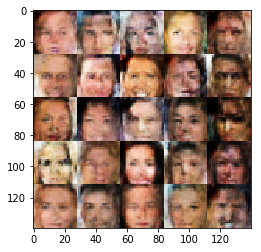

Epoch 2/2... Batch 4110... Discriminator Loss: 1.1384... Generator Loss: 1.1600
Epoch 2/2... Batch 4120... Discriminator Loss: 1.1883... Generator Loss: 0.9027
Epoch 2/2... Batch 4130... Discriminator Loss: 1.1853... Generator Loss: 0.9379
Epoch 2/2... Batch 4140... Discriminator Loss: 1.2335... Generator Loss: 0.8807
Epoch 2/2... Batch 4150... Discriminator Loss: 1.1746... Generator Loss: 0.9917
Epoch 2/2... Batch 4160... Discriminator Loss: 1.1558... Generator Loss: 1.1098
Epoch 2/2... Batch 4170... Discriminator Loss: 1.1395... Generator Loss: 1.0891
Epoch 2/2... Batch 4180... Discriminator Loss: 1.1341... Generator Loss: 1.0934
Epoch 2/2... Batch 4190... Discriminator Loss: 1.0553... Generator Loss: 1.6490
Epoch 2/2... Batch 4200... Discriminator Loss: 1.2323... Generator Loss: 0.8320


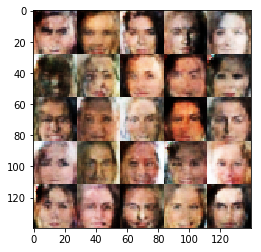

Epoch 2/2... Batch 4210... Discriminator Loss: 1.1713... Generator Loss: 1.0497
Epoch 2/2... Batch 4220... Discriminator Loss: 1.2370... Generator Loss: 0.9075
Epoch 2/2... Batch 4230... Discriminator Loss: 1.1789... Generator Loss: 1.1007
Epoch 2/2... Batch 4240... Discriminator Loss: 1.0336... Generator Loss: 1.2486
Epoch 2/2... Batch 4250... Discriminator Loss: 1.1669... Generator Loss: 0.9755
Epoch 2/2... Batch 4260... Discriminator Loss: 1.2392... Generator Loss: 0.8577
Epoch 2/2... Batch 4270... Discriminator Loss: 1.1970... Generator Loss: 0.9713
Epoch 2/2... Batch 4280... Discriminator Loss: 1.0420... Generator Loss: 1.1220
Epoch 2/2... Batch 4290... Discriminator Loss: 0.9817... Generator Loss: 1.2912
Epoch 2/2... Batch 4300... Discriminator Loss: 1.1688... Generator Loss: 1.1197


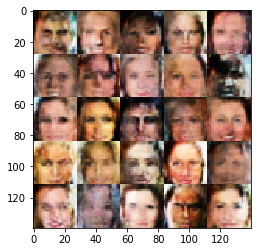

Epoch 2/2... Batch 4310... Discriminator Loss: 1.2699... Generator Loss: 0.9009
Epoch 2/2... Batch 4320... Discriminator Loss: 1.1585... Generator Loss: 1.0069
Epoch 2/2... Batch 4330... Discriminator Loss: 1.2669... Generator Loss: 0.9390
Epoch 2/2... Batch 4340... Discriminator Loss: 1.2228... Generator Loss: 0.9630
Epoch 2/2... Batch 4350... Discriminator Loss: 1.1660... Generator Loss: 0.9847
Epoch 2/2... Batch 4360... Discriminator Loss: 1.1596... Generator Loss: 1.0362
Epoch 2/2... Batch 4370... Discriminator Loss: 1.0369... Generator Loss: 1.1500
Epoch 2/2... Batch 4380... Discriminator Loss: 1.1440... Generator Loss: 0.9312
Epoch 2/2... Batch 4390... Discriminator Loss: 1.1565... Generator Loss: 1.0480
Epoch 2/2... Batch 4400... Discriminator Loss: 1.0977... Generator Loss: 1.2696


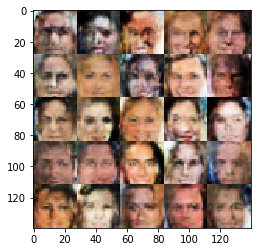

Epoch 2/2... Batch 4410... Discriminator Loss: 1.2899... Generator Loss: 0.7860
Epoch 2/2... Batch 4420... Discriminator Loss: 1.2334... Generator Loss: 0.9325
Epoch 2/2... Batch 4430... Discriminator Loss: 1.2240... Generator Loss: 1.1604
Epoch 2/2... Batch 4440... Discriminator Loss: 1.1424... Generator Loss: 1.0912
Epoch 2/2... Batch 4450... Discriminator Loss: 1.2150... Generator Loss: 0.8797
Epoch 2/2... Batch 4460... Discriminator Loss: 1.2648... Generator Loss: 0.7851
Epoch 2/2... Batch 4470... Discriminator Loss: 1.3662... Generator Loss: 0.8597
Epoch 2/2... Batch 4480... Discriminator Loss: 1.1579... Generator Loss: 0.9431
Epoch 2/2... Batch 4490... Discriminator Loss: 1.1033... Generator Loss: 0.9243
Epoch 2/2... Batch 4500... Discriminator Loss: 1.2479... Generator Loss: 0.9302


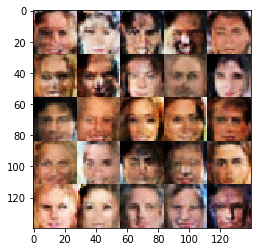

Epoch 2/2... Batch 4510... Discriminator Loss: 1.2116... Generator Loss: 0.9588
Epoch 2/2... Batch 4520... Discriminator Loss: 1.1015... Generator Loss: 1.1568
Epoch 2/2... Batch 4530... Discriminator Loss: 1.0304... Generator Loss: 1.4475
Epoch 2/2... Batch 4540... Discriminator Loss: 1.2562... Generator Loss: 0.9842
Epoch 2/2... Batch 4550... Discriminator Loss: 1.1552... Generator Loss: 1.0496
Epoch 2/2... Batch 4560... Discriminator Loss: 0.9932... Generator Loss: 1.4984
Epoch 2/2... Batch 4570... Discriminator Loss: 1.2465... Generator Loss: 0.9283
Epoch 2/2... Batch 4580... Discriminator Loss: 1.1444... Generator Loss: 1.1196
Epoch 2/2... Batch 4590... Discriminator Loss: 1.1910... Generator Loss: 1.0232
Epoch 2/2... Batch 4600... Discriminator Loss: 1.1926... Generator Loss: 1.0122


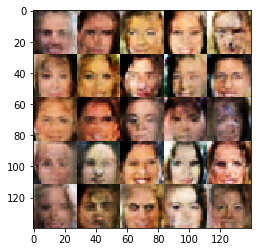

Epoch 2/2... Batch 4610... Discriminator Loss: 1.2525... Generator Loss: 0.9046
Epoch 2/2... Batch 4620... Discriminator Loss: 1.1264... Generator Loss: 0.9543
Epoch 2/2... Batch 4630... Discriminator Loss: 1.2942... Generator Loss: 0.8110
Epoch 2/2... Batch 4640... Discriminator Loss: 1.2608... Generator Loss: 0.8354
Epoch 2/2... Batch 4650... Discriminator Loss: 1.2431... Generator Loss: 0.8631
Epoch 2/2... Batch 4660... Discriminator Loss: 1.3188... Generator Loss: 0.8358
Epoch 2/2... Batch 4670... Discriminator Loss: 1.1911... Generator Loss: 1.0763
Epoch 2/2... Batch 4680... Discriminator Loss: 1.2497... Generator Loss: 0.9207
Epoch 2/2... Batch 4690... Discriminator Loss: 1.1592... Generator Loss: 0.8682
Epoch 2/2... Batch 4700... Discriminator Loss: 1.1893... Generator Loss: 1.0125


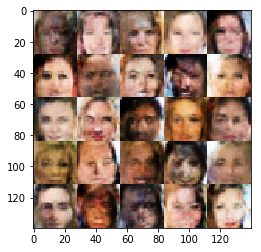

Epoch 2/2... Batch 4710... Discriminator Loss: 1.1586... Generator Loss: 1.0674
Epoch 2/2... Batch 4720... Discriminator Loss: 1.1909... Generator Loss: 1.0304
Epoch 2/2... Batch 4730... Discriminator Loss: 1.2392... Generator Loss: 0.9409
Epoch 2/2... Batch 4740... Discriminator Loss: 1.2315... Generator Loss: 0.9431
Epoch 2/2... Batch 4750... Discriminator Loss: 1.1211... Generator Loss: 1.1429
Epoch 2/2... Batch 4760... Discriminator Loss: 1.3026... Generator Loss: 0.9012
Epoch 2/2... Batch 4770... Discriminator Loss: 1.1351... Generator Loss: 1.1438
Epoch 2/2... Batch 4780... Discriminator Loss: 1.2216... Generator Loss: 0.9350
Epoch 2/2... Batch 4790... Discriminator Loss: 1.2555... Generator Loss: 0.9045
Epoch 2/2... Batch 4800... Discriminator Loss: 1.2682... Generator Loss: 0.9751


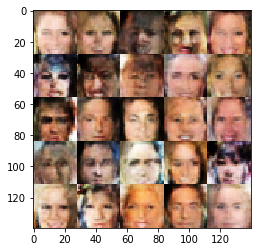

Epoch 2/2... Batch 4810... Discriminator Loss: 1.2235... Generator Loss: 0.9581
Epoch 2/2... Batch 4820... Discriminator Loss: 1.2807... Generator Loss: 0.8939
Epoch 2/2... Batch 4830... Discriminator Loss: 1.2329... Generator Loss: 0.9724
Epoch 2/2... Batch 4840... Discriminator Loss: 1.2380... Generator Loss: 0.9734
Epoch 2/2... Batch 4850... Discriminator Loss: 1.3999... Generator Loss: 0.9598
Epoch 2/2... Batch 4860... Discriminator Loss: 1.2623... Generator Loss: 0.8628
Epoch 2/2... Batch 4870... Discriminator Loss: 1.2670... Generator Loss: 0.9166
Epoch 2/2... Batch 4880... Discriminator Loss: 1.3133... Generator Loss: 0.7994
Epoch 2/2... Batch 4890... Discriminator Loss: 1.1857... Generator Loss: 1.0476
Epoch 2/2... Batch 4900... Discriminator Loss: 1.3012... Generator Loss: 0.8402


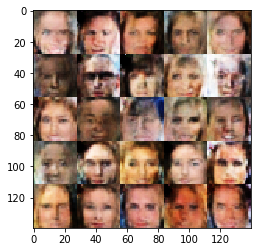

Epoch 2/2... Batch 4910... Discriminator Loss: 1.2694... Generator Loss: 0.8782
Epoch 2/2... Batch 4920... Discriminator Loss: 1.2234... Generator Loss: 0.8673
Epoch 2/2... Batch 4930... Discriminator Loss: 1.3307... Generator Loss: 0.8318
Epoch 2/2... Batch 4940... Discriminator Loss: 1.2959... Generator Loss: 0.8972
Epoch 2/2... Batch 4950... Discriminator Loss: 1.1931... Generator Loss: 0.9243
Epoch 2/2... Batch 4960... Discriminator Loss: 1.0487... Generator Loss: 1.2830
Epoch 2/2... Batch 4970... Discriminator Loss: 1.3140... Generator Loss: 0.8230
Epoch 2/2... Batch 4980... Discriminator Loss: 1.1870... Generator Loss: 0.9624
Epoch 2/2... Batch 4990... Discriminator Loss: 1.2353... Generator Loss: 0.9005
Epoch 2/2... Batch 5000... Discriminator Loss: 1.2499... Generator Loss: 0.9003


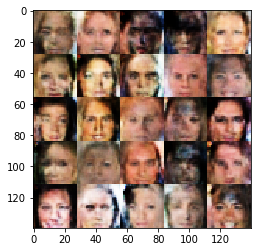

Epoch 2/2... Batch 5010... Discriminator Loss: 1.2245... Generator Loss: 0.8893
Epoch 2/2... Batch 5020... Discriminator Loss: 1.1294... Generator Loss: 1.1226
Epoch 2/2... Batch 5030... Discriminator Loss: 1.1597... Generator Loss: 0.9801
Epoch 2/2... Batch 5040... Discriminator Loss: 1.2425... Generator Loss: 0.8893
Epoch 2/2... Batch 5050... Discriminator Loss: 1.2340... Generator Loss: 1.0045
Epoch 2/2... Batch 5060... Discriminator Loss: 1.0771... Generator Loss: 1.5403
Epoch 2/2... Batch 5070... Discriminator Loss: 1.2615... Generator Loss: 0.9078
Epoch 2/2... Batch 5080... Discriminator Loss: 1.2551... Generator Loss: 0.8577
Epoch 2/2... Batch 5090... Discriminator Loss: 1.0378... Generator Loss: 1.4712
Epoch 2/2... Batch 5100... Discriminator Loss: 1.2447... Generator Loss: 0.8560


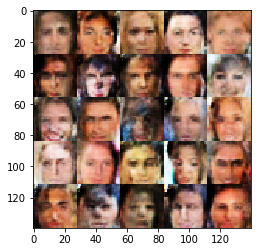

Epoch 2/2... Batch 5110... Discriminator Loss: 1.1449... Generator Loss: 1.1597
Epoch 2/2... Batch 5120... Discriminator Loss: 1.2345... Generator Loss: 0.9186
Epoch 2/2... Batch 5130... Discriminator Loss: 1.2619... Generator Loss: 0.8588
Epoch 2/2... Batch 5140... Discriminator Loss: 1.1704... Generator Loss: 1.1146
Epoch 2/2... Batch 5150... Discriminator Loss: 1.3466... Generator Loss: 0.9174
Epoch 2/2... Batch 5160... Discriminator Loss: 1.2761... Generator Loss: 0.8868
Epoch 2/2... Batch 5170... Discriminator Loss: 1.3270... Generator Loss: 0.8544
Epoch 2/2... Batch 5180... Discriminator Loss: 1.2574... Generator Loss: 0.8228
Epoch 2/2... Batch 5190... Discriminator Loss: 1.2452... Generator Loss: 0.8667
Epoch 2/2... Batch 5200... Discriminator Loss: 1.3654... Generator Loss: 1.0264


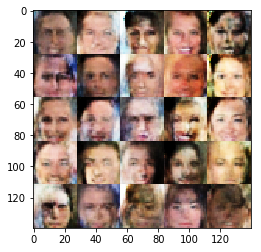

Epoch 2/2... Batch 5210... Discriminator Loss: 1.2448... Generator Loss: 0.8764
Epoch 2/2... Batch 5220... Discriminator Loss: 1.2050... Generator Loss: 1.0420
Epoch 2/2... Batch 5230... Discriminator Loss: 1.3728... Generator Loss: 0.7645
Epoch 2/2... Batch 5240... Discriminator Loss: 1.2118... Generator Loss: 0.8742
Epoch 2/2... Batch 5250... Discriminator Loss: 1.2959... Generator Loss: 0.9110
Epoch 2/2... Batch 5260... Discriminator Loss: 1.2345... Generator Loss: 0.8437
Epoch 2/2... Batch 5270... Discriminator Loss: 1.1748... Generator Loss: 1.0595
Epoch 2/2... Batch 5280... Discriminator Loss: 1.2391... Generator Loss: 1.1081
Epoch 2/2... Batch 5290... Discriminator Loss: 1.2408... Generator Loss: 0.9113
Epoch 2/2... Batch 5300... Discriminator Loss: 1.3013... Generator Loss: 0.7636


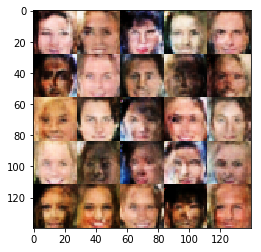

Epoch 2/2... Batch 5310... Discriminator Loss: 1.3403... Generator Loss: 0.8761
Epoch 2/2... Batch 5320... Discriminator Loss: 1.0723... Generator Loss: 1.3486
Epoch 2/2... Batch 5330... Discriminator Loss: 1.2964... Generator Loss: 0.8710
Epoch 2/2... Batch 5340... Discriminator Loss: 1.2014... Generator Loss: 0.9815
Epoch 2/2... Batch 5350... Discriminator Loss: 1.3083... Generator Loss: 0.9604
Epoch 2/2... Batch 5360... Discriminator Loss: 1.2724... Generator Loss: 0.8686
Epoch 2/2... Batch 5370... Discriminator Loss: 1.3542... Generator Loss: 0.8254
Epoch 2/2... Batch 5380... Discriminator Loss: 1.2706... Generator Loss: 0.8575
Epoch 2/2... Batch 5390... Discriminator Loss: 1.1951... Generator Loss: 0.9870
Epoch 2/2... Batch 5400... Discriminator Loss: 1.2593... Generator Loss: 0.8802


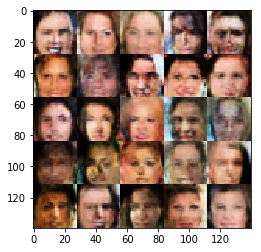

Epoch 2/2... Batch 5410... Discriminator Loss: 1.3002... Generator Loss: 0.8419
Epoch 2/2... Batch 5420... Discriminator Loss: 1.1614... Generator Loss: 1.0192
Epoch 2/2... Batch 5430... Discriminator Loss: 1.2955... Generator Loss: 0.9343
Epoch 2/2... Batch 5440... Discriminator Loss: 1.3420... Generator Loss: 0.9322
Epoch 2/2... Batch 5450... Discriminator Loss: 1.2652... Generator Loss: 0.8944
Epoch 2/2... Batch 5460... Discriminator Loss: 1.1800... Generator Loss: 1.0409
Epoch 2/2... Batch 5470... Discriminator Loss: 1.3302... Generator Loss: 0.8128
Epoch 2/2... Batch 5480... Discriminator Loss: 1.2934... Generator Loss: 0.8334
Epoch 2/2... Batch 5490... Discriminator Loss: 1.3782... Generator Loss: 0.9971
Epoch 2/2... Batch 5500... Discriminator Loss: 1.2829... Generator Loss: 0.7966


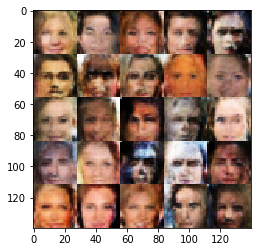

Epoch 2/2... Batch 5510... Discriminator Loss: 1.1874... Generator Loss: 1.1836
Epoch 2/2... Batch 5520... Discriminator Loss: 1.1134... Generator Loss: 1.1475
Epoch 2/2... Batch 5530... Discriminator Loss: 1.3050... Generator Loss: 0.8692
Epoch 2/2... Batch 5540... Discriminator Loss: 1.3703... Generator Loss: 0.8262
Epoch 2/2... Batch 5550... Discriminator Loss: 1.2676... Generator Loss: 0.9696
Epoch 2/2... Batch 5560... Discriminator Loss: 1.2962... Generator Loss: 0.9037
Epoch 2/2... Batch 5570... Discriminator Loss: 1.2354... Generator Loss: 1.0817
Epoch 2/2... Batch 5580... Discriminator Loss: 1.3002... Generator Loss: 0.8612
Epoch 2/2... Batch 5590... Discriminator Loss: 1.3066... Generator Loss: 0.9432
Epoch 2/2... Batch 5600... Discriminator Loss: 1.3196... Generator Loss: 0.7721


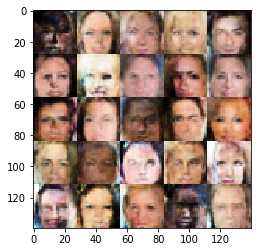

Epoch 2/2... Batch 5610... Discriminator Loss: 1.2393... Generator Loss: 0.9573
Epoch 2/2... Batch 5620... Discriminator Loss: 1.2197... Generator Loss: 1.0074
Epoch 2/2... Batch 5630... Discriminator Loss: 1.2448... Generator Loss: 0.9698
Epoch 2/2... Batch 5640... Discriminator Loss: 1.3026... Generator Loss: 0.8094
Epoch 2/2... Batch 5650... Discriminator Loss: 1.4000... Generator Loss: 0.8647
Epoch 2/2... Batch 5660... Discriminator Loss: 1.2079... Generator Loss: 0.9320
Epoch 2/2... Batch 5670... Discriminator Loss: 1.3345... Generator Loss: 0.8715
Epoch 2/2... Batch 5680... Discriminator Loss: 1.2812... Generator Loss: 0.9915
Epoch 2/2... Batch 5690... Discriminator Loss: 1.4062... Generator Loss: 0.8582
Epoch 2/2... Batch 5700... Discriminator Loss: 1.2565... Generator Loss: 0.9705


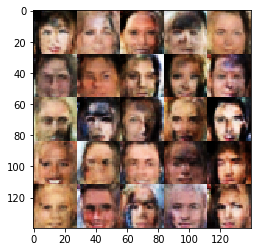

Epoch 2/2... Batch 5710... Discriminator Loss: 1.2322... Generator Loss: 1.0032
Epoch 2/2... Batch 5720... Discriminator Loss: 1.1395... Generator Loss: 1.1050
Epoch 2/2... Batch 5730... Discriminator Loss: 1.0206... Generator Loss: 1.4612
Epoch 2/2... Batch 5740... Discriminator Loss: 1.3903... Generator Loss: 0.7915
Epoch 2/2... Batch 5750... Discriminator Loss: 1.3365... Generator Loss: 0.9476
Epoch 2/2... Batch 5760... Discriminator Loss: 1.3807... Generator Loss: 0.7833
Epoch 2/2... Batch 5770... Discriminator Loss: 1.2623... Generator Loss: 0.9059
Epoch 2/2... Batch 5780... Discriminator Loss: 1.3020... Generator Loss: 0.7912
Epoch 2/2... Batch 5790... Discriminator Loss: 1.3974... Generator Loss: 0.8252
Epoch 2/2... Batch 5800... Discriminator Loss: 1.2564... Generator Loss: 1.0199


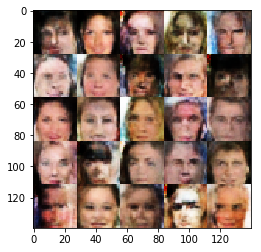

Epoch 2/2... Batch 5810... Discriminator Loss: 1.3527... Generator Loss: 0.8067
Epoch 2/2... Batch 5820... Discriminator Loss: 1.3008... Generator Loss: 0.8625
Epoch 2/2... Batch 5830... Discriminator Loss: 1.3025... Generator Loss: 0.9799
Epoch 2/2... Batch 5840... Discriminator Loss: 1.2832... Generator Loss: 0.7444
Epoch 2/2... Batch 5850... Discriminator Loss: 1.2499... Generator Loss: 0.9269
Epoch 2/2... Batch 5860... Discriminator Loss: 1.3856... Generator Loss: 0.8409
Epoch 2/2... Batch 5870... Discriminator Loss: 1.2811... Generator Loss: 0.9942
Epoch 2/2... Batch 5880... Discriminator Loss: 1.1771... Generator Loss: 1.0187
Epoch 2/2... Batch 5890... Discriminator Loss: 1.1503... Generator Loss: 1.2089
Epoch 2/2... Batch 5900... Discriminator Loss: 1.3534... Generator Loss: 0.8688


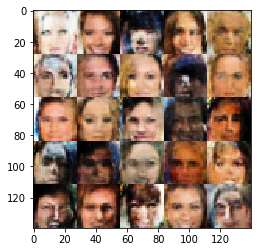

Epoch 2/2... Batch 5910... Discriminator Loss: 1.3116... Generator Loss: 0.9218
Epoch 2/2... Batch 5920... Discriminator Loss: 1.3079... Generator Loss: 0.9536
Epoch 2/2... Batch 5930... Discriminator Loss: 1.3910... Generator Loss: 0.7810
Epoch 2/2... Batch 5940... Discriminator Loss: 1.3377... Generator Loss: 0.8246
Epoch 2/2... Batch 5950... Discriminator Loss: 1.3547... Generator Loss: 0.7382
Epoch 2/2... Batch 5960... Discriminator Loss: 1.1808... Generator Loss: 0.9485
Epoch 2/2... Batch 5970... Discriminator Loss: 1.3968... Generator Loss: 0.7127
Epoch 2/2... Batch 5980... Discriminator Loss: 1.2231... Generator Loss: 0.9224
Epoch 2/2... Batch 5990... Discriminator Loss: 1.2528... Generator Loss: 0.9201
Epoch 2/2... Batch 6000... Discriminator Loss: 1.3676... Generator Loss: 0.7569


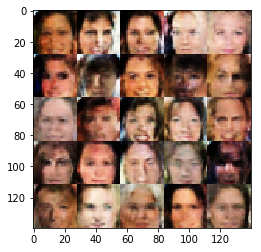

Epoch 2/2... Batch 6010... Discriminator Loss: 1.3793... Generator Loss: 0.8018
Epoch 2/2... Batch 6020... Discriminator Loss: 1.2338... Generator Loss: 1.0048
Epoch 2/2... Batch 6030... Discriminator Loss: 1.1483... Generator Loss: 1.3967
Epoch 2/2... Batch 6040... Discriminator Loss: 1.3526... Generator Loss: 0.8516
Epoch 2/2... Batch 6050... Discriminator Loss: 1.3609... Generator Loss: 0.7331
Epoch 2/2... Batch 6060... Discriminator Loss: 1.3221... Generator Loss: 0.8461
Epoch 2/2... Batch 6070... Discriminator Loss: 1.4132... Generator Loss: 0.7371
Epoch 2/2... Batch 6080... Discriminator Loss: 1.1943... Generator Loss: 1.0833
Epoch 2/2... Batch 6090... Discriminator Loss: 1.3270... Generator Loss: 0.8494
Epoch 2/2... Batch 6100... Discriminator Loss: 1.3620... Generator Loss: 0.8495


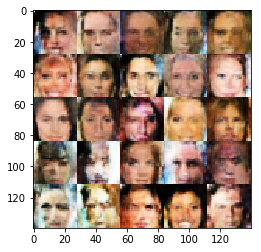

Epoch 2/2... Batch 6110... Discriminator Loss: 1.3294... Generator Loss: 0.7747
Epoch 2/2... Batch 6120... Discriminator Loss: 1.1668... Generator Loss: 1.0226
Epoch 2/2... Batch 6130... Discriminator Loss: 1.4424... Generator Loss: 0.7417
Epoch 2/2... Batch 6140... Discriminator Loss: 1.3251... Generator Loss: 0.8710
Epoch 2/2... Batch 6150... Discriminator Loss: 1.2244... Generator Loss: 0.9588
Epoch 2/2... Batch 6160... Discriminator Loss: 1.3203... Generator Loss: 0.8821
Epoch 2/2... Batch 6170... Discriminator Loss: 1.3475... Generator Loss: 0.8814
Epoch 2/2... Batch 6180... Discriminator Loss: 1.3663... Generator Loss: 0.8085
Epoch 2/2... Batch 6190... Discriminator Loss: 1.2866... Generator Loss: 0.9371
Epoch 2/2... Batch 6200... Discriminator Loss: 1.1035... Generator Loss: 1.3734


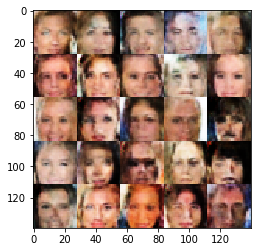

Epoch 2/2... Batch 6210... Discriminator Loss: 1.3706... Generator Loss: 0.7788
Epoch 2/2... Batch 6220... Discriminator Loss: 1.2852... Generator Loss: 0.8313
Epoch 2/2... Batch 6230... Discriminator Loss: 1.3485... Generator Loss: 0.8461
Epoch 2/2... Batch 6240... Discriminator Loss: 1.2327... Generator Loss: 0.9667
Epoch 2/2... Batch 6250... Discriminator Loss: 1.4240... Generator Loss: 0.7008
Epoch 2/2... Batch 6260... Discriminator Loss: 1.3731... Generator Loss: 0.7919
Epoch 2/2... Batch 6270... Discriminator Loss: 1.3139... Generator Loss: 0.8673
Epoch 2/2... Batch 6280... Discriminator Loss: 1.3000... Generator Loss: 0.9078
Epoch 2/2... Batch 6290... Discriminator Loss: 1.4230... Generator Loss: 0.7185
Epoch 2/2... Batch 6300... Discriminator Loss: 1.3255... Generator Loss: 0.7969


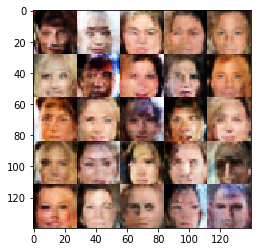

Epoch 2/2... Batch 6310... Discriminator Loss: 1.2995... Generator Loss: 0.8516
Epoch 2/2... Batch 6320... Discriminator Loss: 1.2244... Generator Loss: 1.1560
Epoch 2/2... Batch 6330... Discriminator Loss: 1.3607... Generator Loss: 0.7700


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

# I tried to decrease the learning rate. Not sure whether the result is good enough
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.